In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns 
from sklearn.decomposition import PCA
import joblib
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import levene
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp
from hyperopt.base import STATUS_OK
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import KFold
from xgboost import plot_tree
from sklearn.pipeline import Pipeline 
import xgboost as xgb

%matplotlib inline

In [8]:
def get_accuracy(preds, actuals):
    count = 0

    actuals=[bool(x) for x in actuals]
    preds =[bool(x) for x in preds]
    
    for i in range(len(preds)):
        if preds[i]== actuals[i]:
            count+=1
     
    tp= sum([1 for a, p in zip(actuals, preds) if a and p])
    fp= sum([1 for a, p in zip(actuals, preds) if not a and p])
    tn= sum([1 for a, p in zip(actuals, preds) if not a and not p])
    fn= sum([1 for a, p in zip(actuals, preds) if a and not p])
    
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    
    return count/len(actuals),(tp,fp,tn,fn),(tpr,fpr)

In [9]:
def list_reader(file,  encoding="utf8"):

    import csv

    with open(file, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    data = data[0]

    return data

In [7]:
def list_writer(ur_list, file_name):

    import csv

    with open(file_name, 'w', newline='') as myfile:
         wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
         wr.writerow(ur_list)

In [11]:
#Returns the mutual information for all features. Can do either classification (mode=1) or regression (mode!=1).

def get_mi(df, labels,file_path, mode=1):
    
    if mode:
        # Calculate mutual information between features and class labels
        mi_scores = mutual_info_classif(df, labels)
    else:
        mi_scores = mutual_info_regression(df, labels,random_state=8)
        
    importances = pd.DataFrame({'CpG': df.columns, 'MI': mi_scores})
    importances = importances.sort_values('MI',axis=0, ascending=False)
    importances.to_excel(file_path+'MI_cgs.xlsx')
    
    return(importances)

In [12]:
def cohens_d(s1, s2):
    
    import statistics
    

    diff = s2.mean()-s1.mean()
    
    n1 = len(s1)
    n2 = len(s2)
    sd1 = statistics.stdev(s1)
    sd2 = statistics.stdev(s2)
    
    pooled_sd = np.sqrt(((n1-1)*sd1+(n2-1)*sd2)/(n1+n2-2))
    
    return diff/pooled_sd

# Train an RF using Alzheimers, Pagets and Parkinsons

Need to get the overlap of the top N MI cgs for the three datasets. Start by reading in the MI data

In [2]:
alz_mi = pd.read_excel('Datasets/Alzheimers/MI_cgs.xlsx')
pag_mi = pd.read_excel('Datasets/Pagets/MI_cgs.xlsx')
park_mi = pd.read_excel('Datasets/Parkinsons Vallerga/MI_cgs.xlsx')

In [3]:
overlap = list(set(alz_mi.CpG[:100000])&set(pag_mi.CpG[:100000])&set(park_mi.CpG[:100000]))

In [4]:
len(overlap)

5169

In [8]:
list_writer(overlap, 'Datasets/Combined/RF/MI_overlap.txt')

Code to generate RF/V5_combined

In [2]:
# file_path='Datasets/Alzheimers/'
# alz = np.load(file_path+'No_mci.npy', allow_pickle=True)
# alz_meta = pd.read_excel(file_path+'No_mci_meta.xlsx')
# cgs = list_reader(file_path+'cgs.txt')
# alz = pd.DataFrame(alz, columns=cgs)
# alz=alz[overlap]

# file_path='Datasets/Pagets/'
# pag = np.load(file_path+'Pagets.npy', allow_pickle=True)
# pag_meta = pd.read_excel(file_path+'Pagets_pmeta.xlsx')
# cgs = list_reader(file_path+'cgs.txt')
# pag = pd.DataFrame(pag, columns=cgs)
# pag=pag[overlap]

# file_path='Datasets/Parkinsons Vallerga/'
# park = np.load(file_path+'Parkinsons.npy', allow_pickle=True)
# park_meta = pd.read_excel(file_path+'Parkinsons_Vallerga_pmeta.xlsx')
# cgs = list_reader(file_path+'cgs.txt')
# park = pd.DataFrame(park, columns=cgs)
# park=park[overlap]

# comb = pd.concat([alz,park])
# comb = pd.concat([comb, pag])
# np.save('Datasets/Combined/RF/V5/V5_combined.npy', comb.values)
# list_writer(comb.columns.tolist(), 'Datasets/Combined/RF/V5/V5_combined_cgs.txt')

In [87]:
comb_v5 = np.load('Datasets/Combined/RF/V5/V5_combined.npy', allow_pickle=True)
v5_cgs = list_reader('Datasets/Combined/RF/V5/V5_combined_cgs.txt')
v5_meta = pd.read_excel('Datasets/Combined/RF/V5/V5_combined_pmeta.xlsx')
comb_v5 = pd.DataFrame(comb_v5, columns=v5_cgs)

In [23]:
# #The pagets dataset controls are not trustworthy; 131 of them were suspected to have osteoporosis but were subsequently deemed not to; this means they likely have 
# # some other disease. Remove them from the combined dataset.
# comb_v5 = comb_v5[~(v5_meta.series_ID == 'GSE163970')]
# v5_meta = v5_meta[~(v5_meta.series_ID == 'GSE163970')]

In [72]:
#Separate the v5 dataset by gender for two rf classifiers
v5_male = comb_v5[v5_meta.gender == 'Male']
v5_female = comb_v5[v5_meta.gender == 'Female']

meta_m = v5_meta[v5_meta.gender == 'Male']
meta_f = v5_meta[v5_meta.gender == 'Female']

In [86]:
meta_m

REF_ID      age gender smoking_status        disease_state  disease  \
0     GSM4649388  unknown   Male        unknown              Control        0   
3     GSM4649391  unknown   Male        unknown              Control        0   
6     GSM4649394  unknown   Male        unknown  Alzheimer's disease        1   
8     GSM4649397  unknown   Male        unknown              Control        0   
9     GSM4649398  unknown   Male        unknown              Control        0   
...          ...      ...    ...            ...                  ...      ...   
2512  GSM4317285  unknown   Male        unknown              Control        0   
2513  GSM4317286  unknown   Male        unknown  Parkinson's disease        1   
2514  GSM4317287  unknown   Male        unknown  Parkinson's disease        1   
2516  GSM4317289  unknown   Male        unknown              Control        0   
2518  GSM4317291  unknown   Male        unknown  Parkinson's disease        1   

      series_ID  
0     GSE153712  
3     GSE153712  
6     GSE153712  
8     GSE153712  
9     GSE153712  
...         ...  
2512  GSE145361  
2513  GSE145361  
2514  GSE145361  
2516  GSE145361  
2518  GSE145361  

[1308 rows x 7 columns]

In [34]:
file_path='Datasets/Arthritis/'
art = np.load(file_path+'Arthritis32_full.npy', allow_pickle=True)
art_meta = pd.read_excel(file_path+'Arthritis_pmeta.xlsx')
cgs = list_reader(file_path+'cgs_full.txt')
art = pd.DataFrame(art, columns=cgs)
art = art[v5_cgs]

In [39]:
art_male = art[art_meta.gender == 'Male']
art_female = art[art_meta.gender == 'Female']

art_meta_m = art_meta[art_meta.gender == 'Male']
art_meta_f = art_meta[art_meta.gender == 'Female']

In [14]:
file_path='Datasets/Alzheimers/'
alz = np.load(file_path+'No_mci.npy', allow_pickle=True)
alz_meta = pd.read_excel(file_path+'No_mci_meta.xlsx')
cgs = list_reader(file_path+'cgs.txt')
alz = pd.DataFrame(alz, columns=cgs)
alz=alz[v5_cgs]

In [35]:
file_path='Datasets/Depression/'
dep = np.load(file_path+'Depression32_full.npy', allow_pickle=True)
dep_meta = pd.read_excel(file_path+'Depression_pmeta.xlsx')
dep_cgs = list_reader(file_path+'cgs_full.txt')
dep = pd.DataFrame(dep, columns=dep_cgs)
dep = dep[v5_cgs]

In [38]:
file_path = 'Datasets/MS/'
ms = pd.read_pickle(file_path+'MS32.pkl')
ms_meta = pd.read_excel('Datasets/MS/MS_pmeta.xlsx')
ms=ms[v5_cgs]

from sklearn.impute import KNNImputer
# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=3)
# Fit and transform the DataFrame with the imputer
imputed_data = imputer.fit_transform(ms)
ms = pd.DataFrame(imputed_data, columns=ms.columns)
del imputed_data

In [37]:
park = pd.read_pickle('Datasets/Parkinsons Horvath/Parkinsons32.pkl')
park_meta = pd.read_excel('Datasets/Parkinsons Horvath/Parkinsons_pmeta.xlsx')
park=park[v5_cgs]

from sklearn.impute import KNNImputer
# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=2)
# Fit and transform the DataFrame with the imputer
imputed_data = imputer.fit_transform(park)
park = pd.DataFrame(imputed_data, columns=park.columns)
del imputed_data
park.isna().any().any()

False

In [65]:
park_male = park[park_meta.gender == 'Male']
park_female = park[park_meta.gender == 'Female']

park_meta_m = park_meta[park_meta.gender == 'Male']
park_meta_f = park_meta[park_meta.gender == 'Female']

In [36]:
tau = np.load('Datasets/Tauopathy/Tauopathy32.npy', allow_pickle=True)
tau_meta = pd.read_excel('Datasets/Tauopathy/Tauopathy_pmeta.xlsx')
tau_cgs = list_reader('Datasets/Tauopathy/cgs.txt')
tau = pd.DataFrame(tau, columns=tau_cgs)
tau = tau[v5_cgs]

In [391]:
# obs = np.load('Datasets/Obesity and Diabetes/Obesity.npy', allow_pickle=True)
obs_meta = pd.read_excel('Datasets/Obesity and Diabetes/Obesity_pmeta.xlsx')
obs_cgs = list_reader('Datasets/Obesity and Diabetes/cgs.txt')
# obs = pd.DataFrame(obs, columns=obs_cgs)
# obs = obs[v5_cgs]

In [534]:
obs2 = np.load('Datasets/Obesity2/Obesity2.npy', allow_pickle=True)
obs2_meta = pd.read_excel('Datasets/Obesity2/Obesity2_pmeta.xlsx')
obs2_cgs = list_reader('Datasets/Obesity2/cgs.txt')
obs2 = pd.DataFrame(obs2, columns=obs2_cgs)
obs2 = obs2[v5_cgs]

In [396]:
file_path = 'Datasets/Arthritis2/'
art2 = np.load(file_path+'Arthritis2.npy', allow_pickle=True)
art2_meta = pd.read_excel(file_path+'Arthritis2_pmeta.xlsx')
art2_cgs = list_reader(file_path+'cgs.txt')
art2 = pd.DataFrame(art2, columns=art2_cgs)
art2 = art2[v5_cgs]

In [651]:
file_path='Datasets/PESA/'
pesa = np.load(file_path+'PESA.npy', allow_pickle=True)
pesa_meta = pd.read_excel(file_path+'PESA_pmeta.xlsx')
cgs = list_reader(file_path+'cgs.txt')
pesa = pd.DataFrame(pesa, columns=cgs)
pesa = pesa[v5_cgs]

### Split the data randomly into training and test sets

In [73]:
x_train, x_val, y_train, y_val = train_test_split(v5_female, meta_f, test_size=0.15, random_state=1)

In [74]:
estimators =[
        ('clf', XGBClassifier(n_jobs=-1, random_state=1))
]

pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=1, ...))])

In [75]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer 

search_space = {
    
    'clf__n_estimators': Integer(25,50),
    'clf__max_depth': Integer(1,4),
    'clf__grow_policy': Categorical(['lossguide']),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5,1.0),
#     'clf__min_child_weight': Real(0.001,10.0),
    'clf__colsample_bytree': Real(0.6,1.0),
    'clf__colsample_bylevel': Real(0.6,1.0),
    'clf__colsample_bynode': Real(0.6,1.0),
    'clf__reg_alpha': Real(0.0,10.0),
    'clf__reg_lambda': Real(0.0,10.0),
    'clf__gamma': Real(0.0,10.0)
}
opt = BayesSearchCV(pipe, search_space, cv = 5, n_iter=10, scoring = 'roc_auc',  random_state=1)

In [76]:
opt.fit(x_train.values, y_train.disease)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=None,
                                                       interaction_constraints=...
                             'clf__max_depth': Integer(low=1, high=4, prior='uniform', transform='normalize'),
                             'clf__n_estimators': Integer(low=25, high=50, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [77]:
print(opt.best_estimator_)

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.8734229759497165,
                               colsample_bynode=0.733842618080433,
                               colsample_bytree=0.6117645226801297, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=4.347750061961955,
                               grow_policy='lossguide', importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.1735056630016637, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=1,
                               max_leaves=None, min_child_weight=None,
                               missing

In [78]:
opt.best_score_

0.6510454306641531

In [79]:
opt.score(art_female.values, art_meta_f.healthy)

0.6784196338498685

In [41]:
print("Best Parameters: ", opt.best_params_)

Best Parameters:  OrderedDict([('clf__colsample_bylevel', 0.7789695811310385), ('clf__colsample_bynode', 0.8074207002007701), ('clf__colsample_bytree', 0.9464991501273874), ('clf__gamma', 6.800400209726694), ('clf__grow_policy', 'lossguide'), ('clf__learning_rate', 0.026043451730689893), ('clf__max_depth', 2), ('clf__n_estimators', 48), ('clf__reg_alpha', 3.3305400272462653), ('clf__reg_lambda', 3.4882571529868085), ('clf__subsample', 0.6342611089651149)])


In [104]:
clf = xgb.XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6497179282036988,
              colsample_bynode=0.09671903981862642,
              colsample_bytree=0.6017911997580419, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.7903972016782452,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.2817502752184049,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, monotone_constraints=None,
              multi_strategy=None, n_estimators=37, n_jobs=-1,objective='binary:logistic',
              num_parallel_tree=None, random_state=1, reg_alpha= 8.877825084545393, 
              reg_lambda=0.14853767953501798, subsample = 0.886993274580417)

In [557]:
## This was the hyperparameter set when doing 50 iterations and 10-fold CV 

clf = xgb.XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1,
              colsample_bynode=0.5,
              colsample_bytree=0.677918602188396, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.071675900739902,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,objective='binary:logistic',
              num_parallel_tree=None, random_state=1, reg_alpha= 0, 
              reg_lambda=0.0, subsample = 1)

In [451]:
clf = xgb.XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7149309258493847,
              colsample_bynode=0.5,
              colsample_bytree=0.5706693035025697, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.7339361217549607,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.06669348548611301,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=-1,objective='binary:logistic',
              num_parallel_tree=None, random_state=1, reg_alpha= 0, 
              reg_lambda=0.09972194904795839, subsample = 1)

# This the current best. This model is designated V6

In [578]:
clf = xgb.XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.915199506103644,
              colsample_bynode=0.5067245252545651,
              colsample_bytree=0.8849339446151477, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.8012056217975583,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.11730133055282148,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, monotone_constraints=None,
              multi_strategy=None, n_estimators=34, n_jobs=-1,objective='binary:logistic',
              num_parallel_tree=None, random_state=1, reg_alpha= 9.809321132259779, 
              reg_lambda=4.087504477769808, subsample = 0.9901496843990193)

In [105]:
clf.fit(comb_v5.values,v5_meta.disease)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6497179282036988,
              colsample_bynode=0.09671903981862642,
              colsample_bytree=0.6017911997580419, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.7903972016782452,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.2817502752184049,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=37, n_jobs=-1,
              num_parallel_tree=None, random_state=1, ...)

In [489]:
# joblib.dump(clf, 'Models/random_forests/V6/rf_V6.joblib')

['Models/random_forests/V6/rf_V6.joblib']

In [8]:
clf = joblib.load('Models/random_forests/V6/rf_V6.joblib')

In [580]:
selection = pd.DataFrame({'CpG': v5_cgs, 'Importance':clf.feature_importances_})
selection=selection[selection.Importance !=0]
selection=selection.sort_values('Importance', axis=0, ascending=False)
# selection.to_excel('Models/random_forests/V6/V6_feature_selection.xlsx')
selection

CpG  Importance
1368  cg19807237    0.042211
3727  cg02014085    0.041553
2756  cg25630838    0.027867
1010  cg05583921    0.019544
3406  cg14471569    0.018520
...          ...         ...
4620  cg21416600    0.001570
3303  cg23580725    0.001482
4581  cg23769785    0.001105
2176  cg24312843    0.001043
3161  cg18182399    0.001032

[187 rows x 2 columns]

In [80]:
preds=opt.predict(art_female.values)

In [81]:
get_accuracy(preds, art_meta_f.healthy)

(0.5345528455284553,
 (33, 9, 230, 220),
 (0.13043478260869565, 0.03765690376569038))

In [82]:
preds = opt.predict(park_female.values)
probs = opt.predict_proba(park_female.values)
get_accuracy(preds, park_meta_f.healthy)

(0.4933920704845815, (15, 5, 97, 110), (0.12, 0.049019607843137254))

In [83]:
dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
park_meta_f['v6 preds'] = preds
park_meta_f['v6 disease_prob'] = dis
park_meta_f['v6 health_prob'] = health

h_probs = park_meta_f[park_meta_f.healthy==0]['v6 disease_prob']
d_probs = park_meta_f[park_meta_f.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U park
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size = cohens_d(h_probs, d_probs)

C:\Users\Colin\AppData\Local\Temp\ipykernel_2308\1634244332.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  park_meta_f['v6 preds'] = preds
C:\Users\Colin\AppData\Local\Temp\ipykernel_2308\1634244332.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  park_meta_f['v6 disease_prob'] = dis
C:\Users\Colin\AppData\Local\Temp\ipykernel_2308\1634244332.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [84]:
art_meta.to_excel('Datasets/Arthritis/Arthritis_pmeta.xlsx')

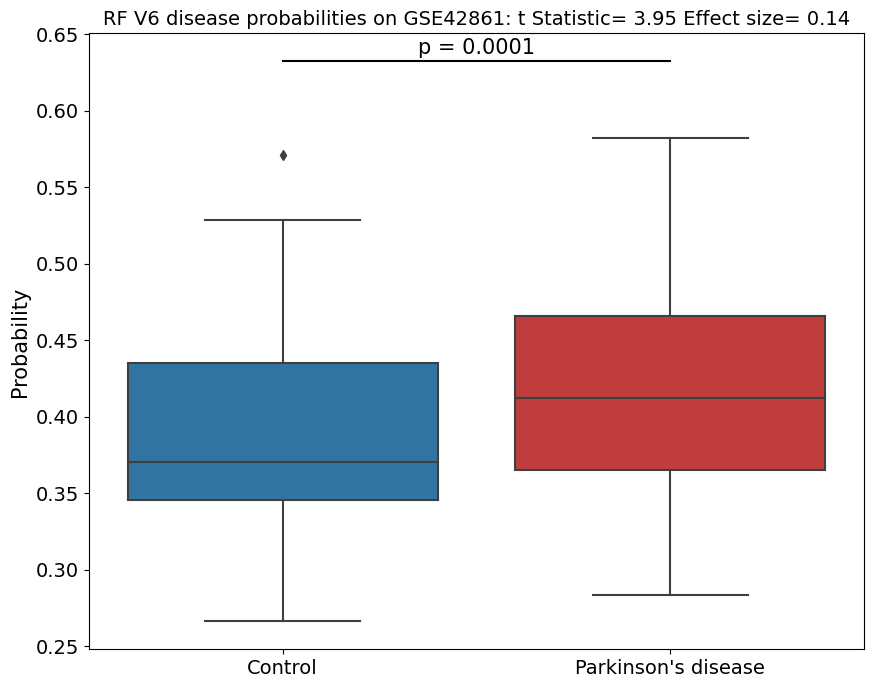

In [85]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

conditions=['Control', 'Parkinson\'s disease']

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=park_meta_f, x='disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V6 disease probabilities on {}: t Statistic= {:.2f} Effect size= {:.2f}'.format(art_meta.series_id[0], statistic, effect_size),fontsize=14) #
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.05, max(d_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

# plt.savefig('Models/random_forests/V6/V6 RF disease probabilities arthritis.png',dpi=300)

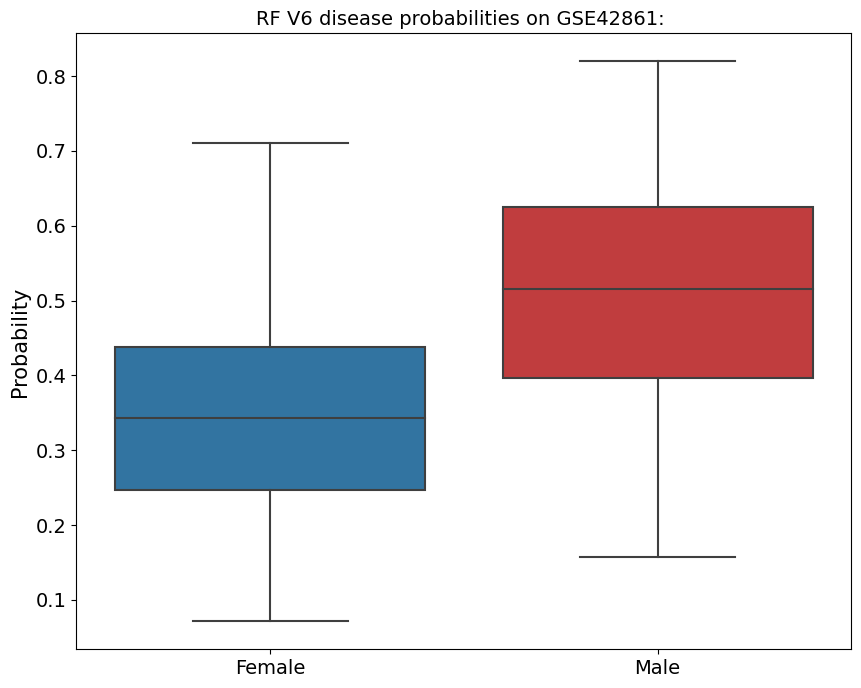

In [111]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

conditions=['Female', 'Male']

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=art_meta, x='gender', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V6 disease probabilities on {}: '.format(art_meta.series_id[0]),fontsize=14)
# Add significance bar and p-value

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
# plt.savefig('Models/random_forests/V6/V6 RF disease probabilities depression.png',dpi=300)

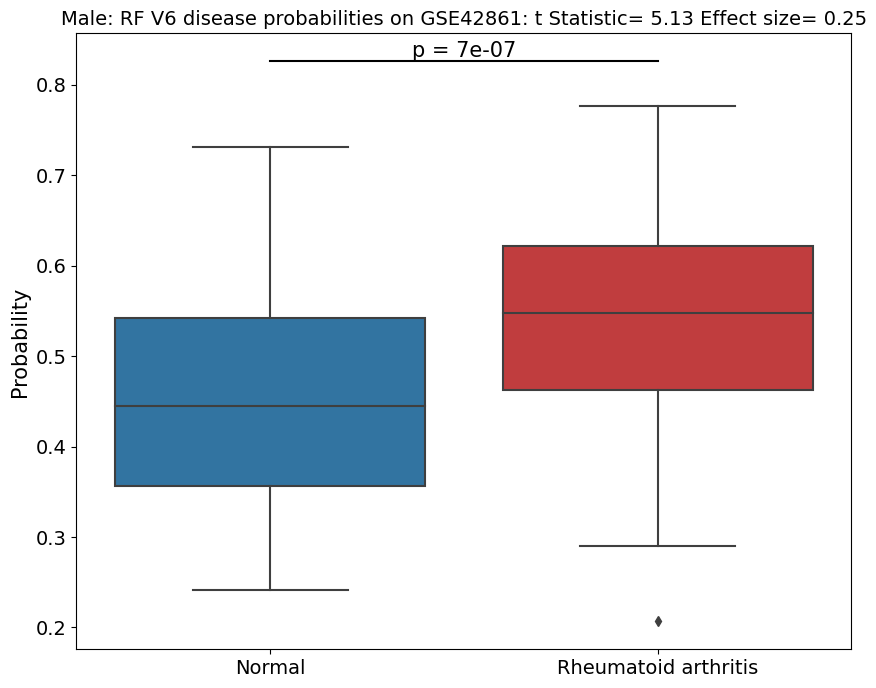

In [69]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

art_meta_m = art_meta[art_meta.gender=='Male']

h_probs = art_meta_m[art_meta_m.healthy==0]['v6 disease_prob']
d_probs = art_meta_m[art_meta_m.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U art
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size = cohens_d(h_probs, d_probs)

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=art_meta_m, x='disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('Male: RF V6 disease probabilities on {}: t Statistic= {:.2f} Effect size= {:.2f}'.format(art_meta.series_id[0], statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.05, max(d_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

# plt.savefig('Models/random_forests/V6/V6 RF disease probabilities arthritis male.png',dpi=300)

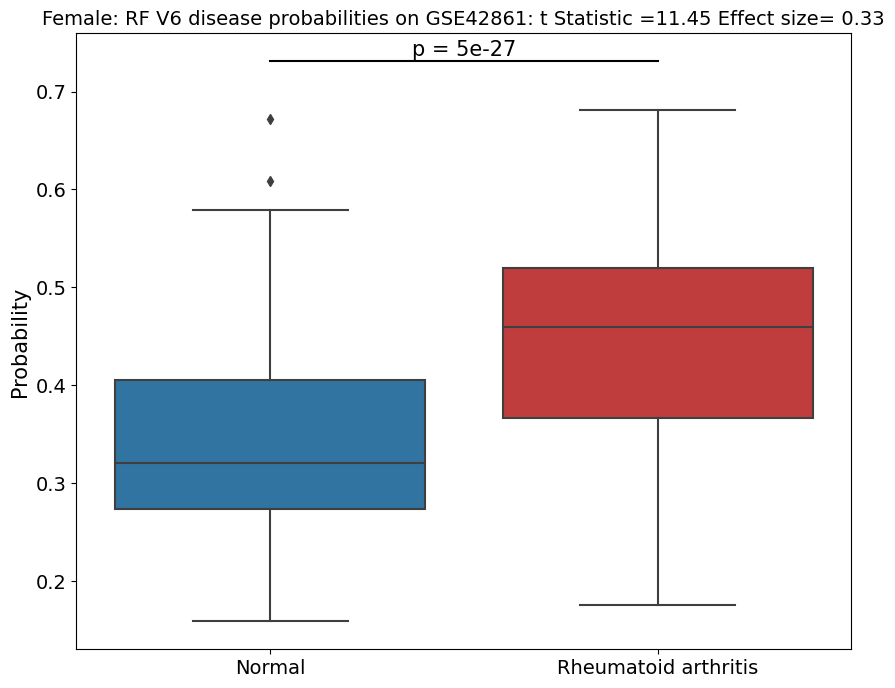

In [70]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

art_meta_f = art_meta[art_meta.gender=='Female']

h_probs = art_meta_f[art_meta_f.healthy==0]['v6 disease_prob']
d_probs = art_meta_f[art_meta_f.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U art
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size = cohens_d(h_probs,d_probs)

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=art_meta_f, x='disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('Female: RF V6 disease probabilities on {}: t Statistic ={:.2f} Effect size= {:.2f}'.format(art_meta.series_id[0],statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.05, max(d_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

# plt.savefig('Models/random_forests/V6/V6 RF disease probabilities arthritis female.png',dpi=300)

<AxesSubplot: xlabel='age', ylabel='v6 disease_prob'>

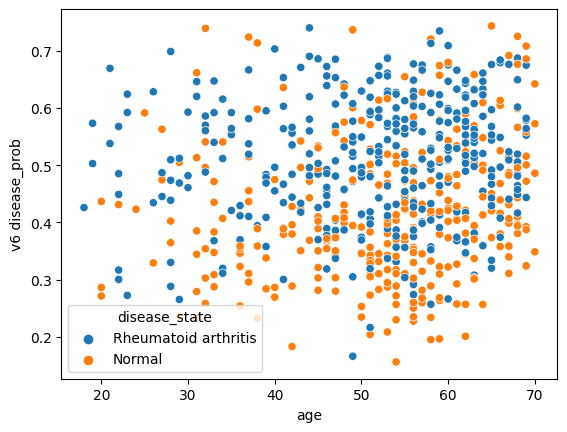

In [586]:
sns.scatterplot(data=art_meta, x = 'age', y='v6 disease_prob', hue = 'disease_state')

In [750]:
preds = clf.predict(pesa.values)
probs = clf.predict_proba(pesa.values)
get_accuracy(preds, pesa_meta.healthy)

dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
pesa_meta['v6 preds'] = preds
pesa_meta['v6 disease_prob'] = dis
pesa_meta['v6 health_prob'] = health

# from scipy.stats import mannwhitneyu
h_probs = pesa_meta[pesa_meta.healthy==0]['v6 disease_prob']
d_probs = pesa_meta[pesa_meta.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U 
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size = cohens_d(h_probs,d_probs)

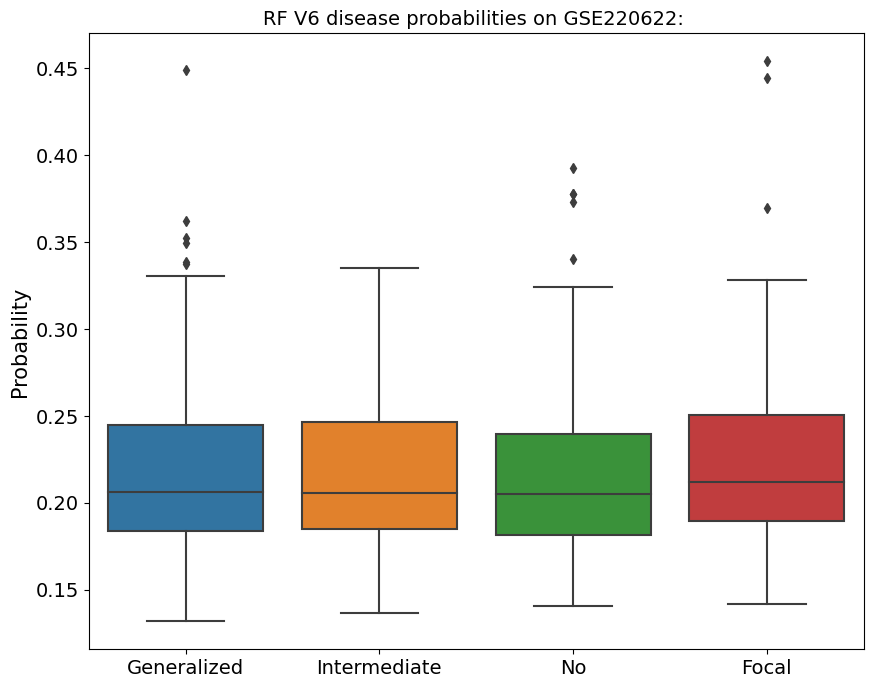

In [751]:
plt.figure(figsize=(10, 8)) 



sns.boxplot(data=pesa_meta, x='disease_state', y='v6 disease_prob')
plt.title('RF V6 disease probabilities on {}: '.format(pesa_meta.series_id[0]),fontsize=14)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

# plt.savefig('Models/random_forests/V6/V6 RF disease probabilities PESA detailed.png',dpi=300)

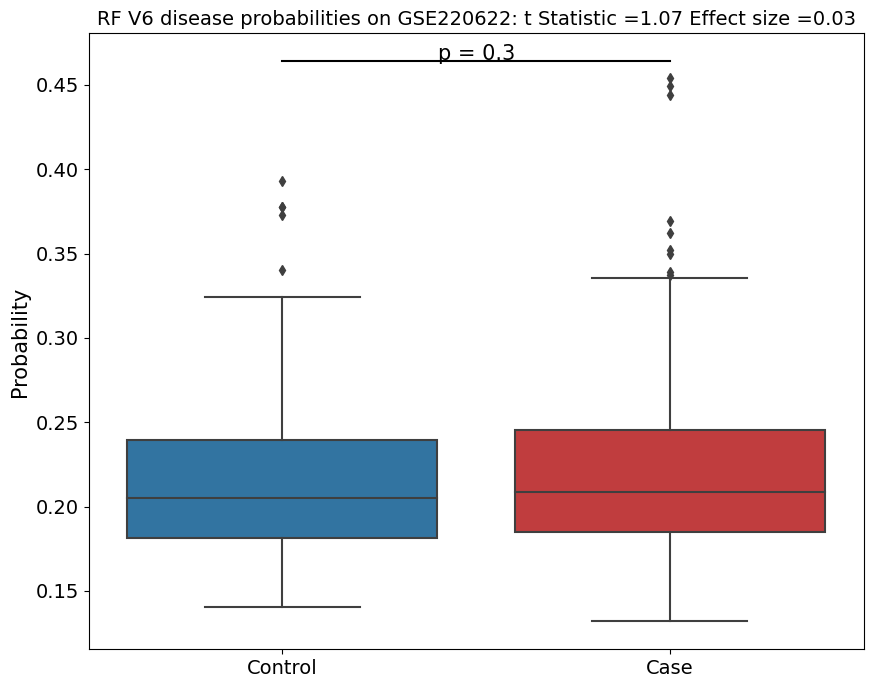

In [754]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

conditions=['Control', 'Case']

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=pesa_meta, x='simple_disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V6 disease probabilities on {}: t Statistic ={:.2f} Effect size ={:.2f}'.format(pesa_meta.series_id[0],statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.01, max(d_probs) + 0.01], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.011, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.savefig('Models/random_forests/V6/V6 RF disease probabilities PESA simple.png',dpi=300)

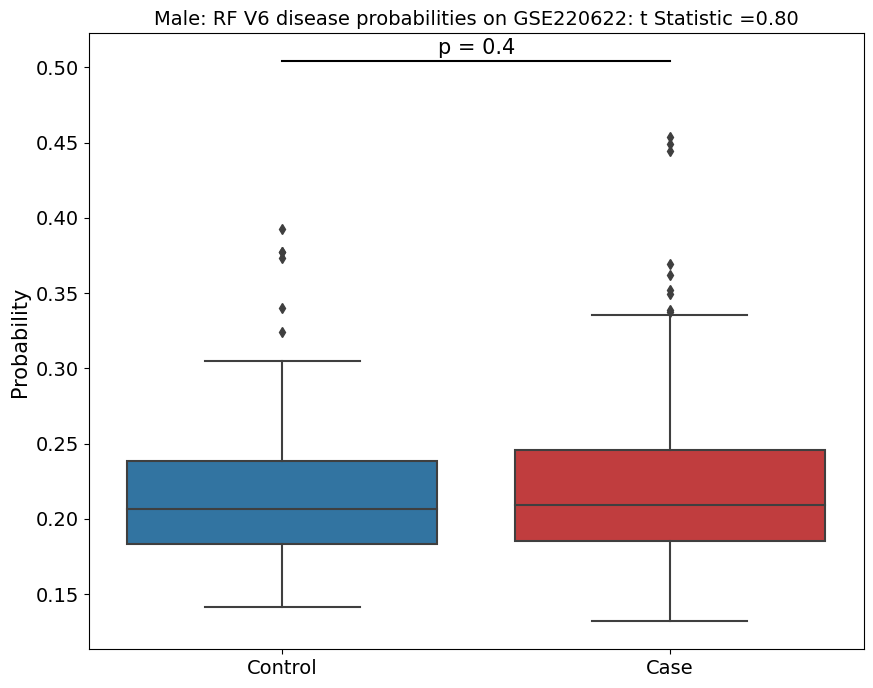

In [757]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

pesa_meta_m = pesa_meta[pesa_meta.gender=='Male']

h_probs = pesa_meta_m[pesa_meta_m.healthy==0]['v6 disease_prob']
d_probs = pesa_meta_m[pesa_meta_m.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U pesa
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size=cohens_d(h_probs, d_probs)

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}

sns.boxplot(data=pesa_meta_m, x='simple_disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('Male: RF V6 disease probabilities on {}: t Statistic ={:.2f}'.format(pesa_meta.series_id[0],statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.05, max(d_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.savefig('Models/random_forests/V6/V6 RF disease probabilities PESA male.png',dpi=300)

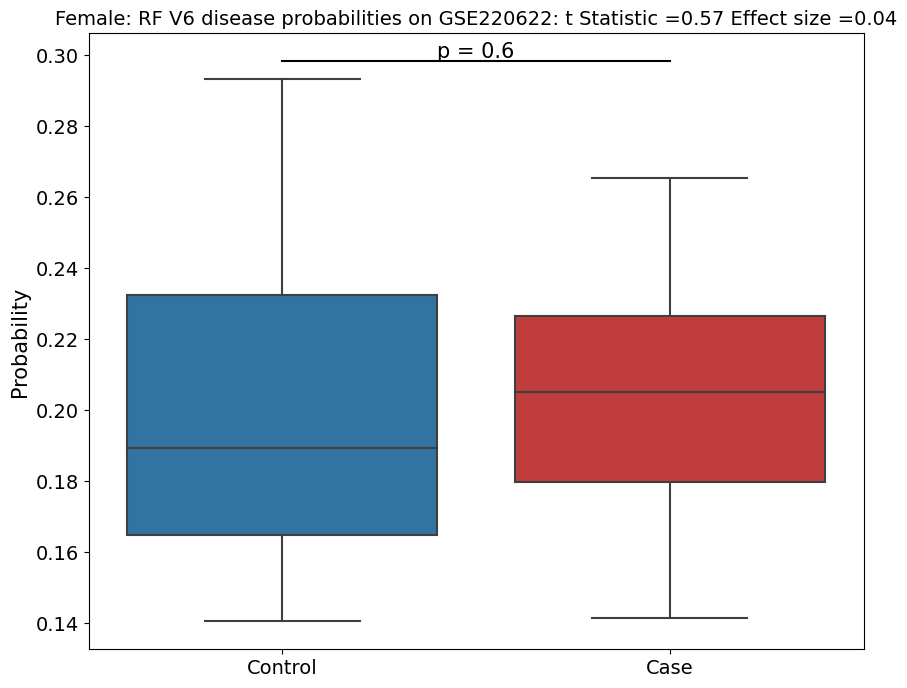

In [765]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

pesa_meta_f = pesa_meta[pesa_meta.gender=='Female']

h_probs = pesa_meta_f[pesa_meta_f.healthy==0]['v6 disease_prob']
d_probs = pesa_meta_f[pesa_meta_f.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U pesa
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size=cohens_d(h_probs, d_probs)

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}

sns.boxplot(data=pesa_meta_f, x='simple_disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('Female: RF V6 disease probabilities on {}: t Statistic ={:.2f} Effect size ={:.2f}'.format(pesa_meta.series_id[0],statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(h_probs) + 0.005, max(h_probs) + 0.005], 'k-', lw=1.5)
plt.text(0.5, max(h_probs) + 0.0058, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.savefig('Models/random_forests/V6/V6 RF disease probabilities PESA female.png',dpi=300)

<AxesSubplot: xlabel='age', ylabel='v6 disease_prob'>

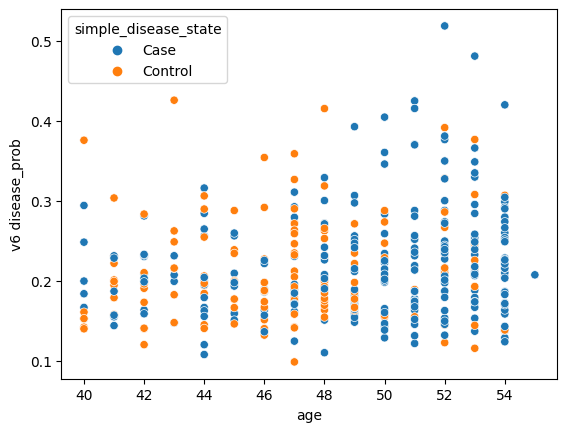

In [569]:
sns.scatterplot(data=pesa_meta, x = 'age', y='v6 disease_prob', hue = 'simple_disease_state')

In [767]:
preds = clf.predict(obs2.values)
probs = clf.predict_proba(obs2.values)
get_accuracy(preds, obs2_meta.healthy)

dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
obs2_meta['v6 preds'] = preds
obs2_meta['v6 disease_prob'] = dis
obs2_meta['v6 health_prob'] = health

from scipy.stats import mannwhitneyu
h_probs = obs2_meta[obs2_meta.healthy==0]['v6 disease_prob']
d_probs = obs2_meta[obs2_meta.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U 
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size = cohens_d(h_probs, d_probs)

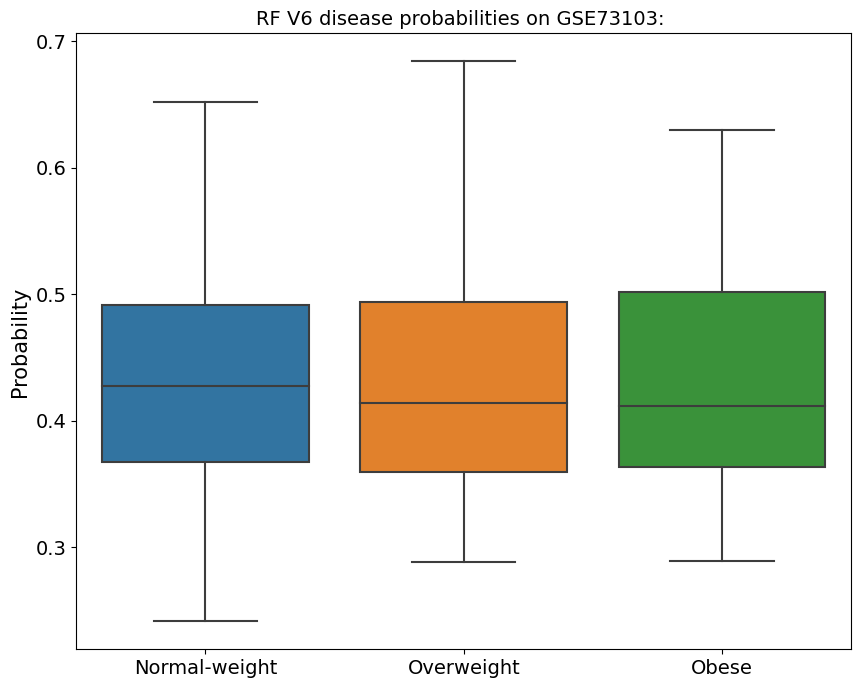

In [768]:
plt.figure(figsize=(10, 8)) 



sns.boxplot(data=obs2_meta, x='disease_state', y='v6 disease_prob')
plt.title('RF V6 disease probabilities on {}: '.format(obs2_meta.series_id[0]),fontsize=14)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

# plt.savefig('Models/random_forests/V6/V6 RF disease probabilities Obesity2 detailed.png',dpi=300)

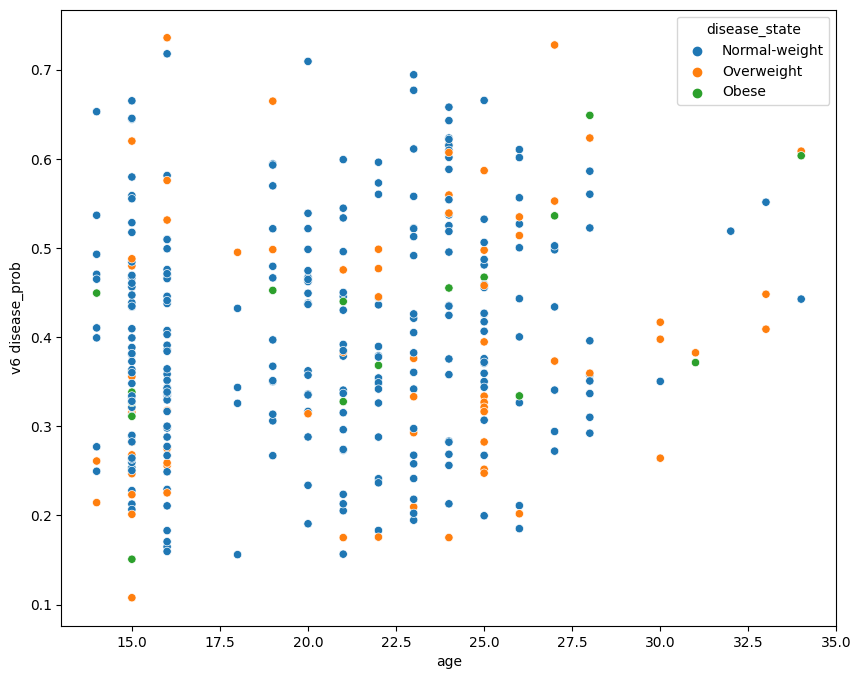

In [592]:
plt.figure(figsize=(10, 8)) 
sns.scatterplot(data=obs2_meta, x = 'age', y='v6 disease_prob', hue = 'disease_state');

In [769]:
preds = clf.predict(obs.values)
probs = clf.predict_proba(obs.values)
get_accuracy(preds, obs_meta.healthy)

dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
obs_meta['v6 preds'] = preds
obs_meta['v6 disease_prob'] = dis
obs_meta['v6 health_prob'] = health

from scipy.stats import mannwhitneyu
h_probs = obs_meta[obs_meta.healthy==0]['v6 disease_prob']
d_probs = obs_meta[obs_meta.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U obs
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size=cohens_d(h_probs, d_probs)

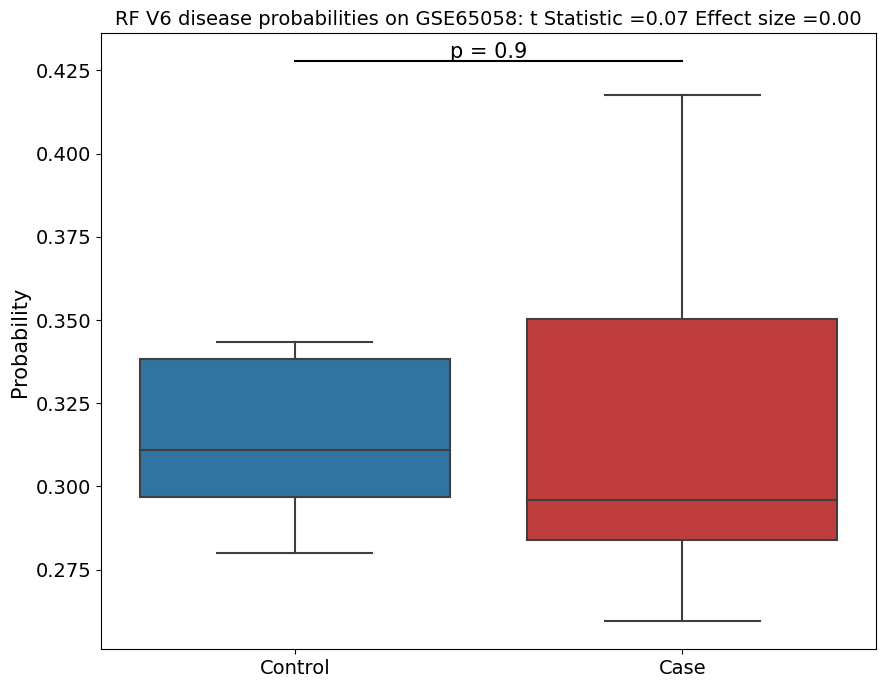

In [771]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

conditions=['Control', 'Case']

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=obs_meta, x='simple_disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V6 disease probabilities on {}: t Statistic ={:.2f} Effect size ={:.2f}'.format(obs_meta.series_id[0],statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.01, max(d_probs) + 0.01], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.011, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.savefig('Models/random_forests/V6/V6 RF disease probabilities Obesity and Diabetes II simple.png',dpi=300)

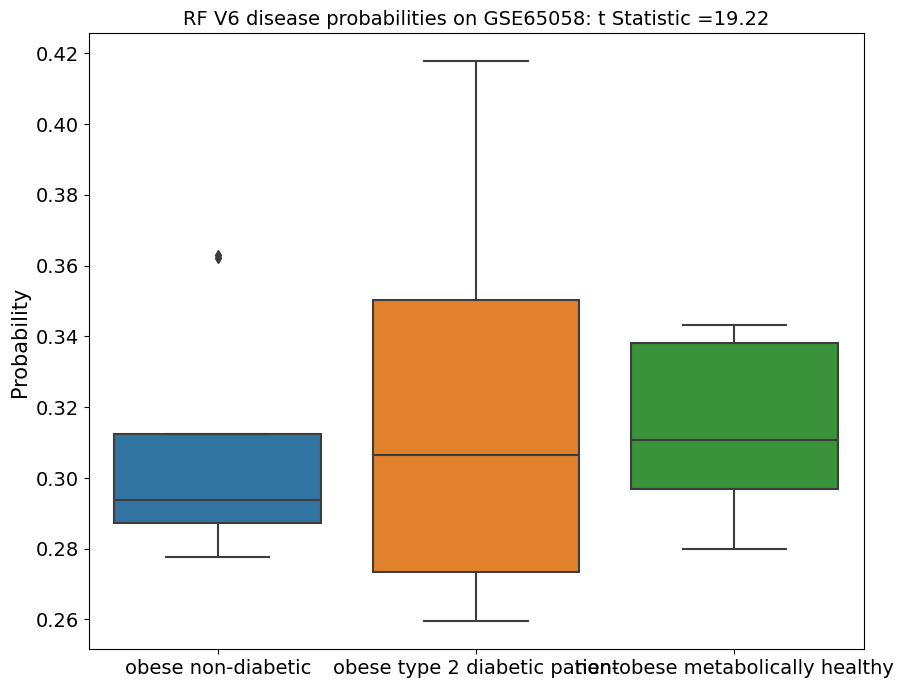

In [597]:
plt.figure(figsize=(10, 8)) 


custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=obs_meta, x='disease_state', y='v6 disease_prob')
plt.title('RF V6 disease probabilities on {}: t Statistic ={:.2f}'.format(obs_meta.series_id[0],statistic, p_value),fontsize=14)
# Add significance bar and p-value
# plt.plot([0, 1], [max(d_probs) + 0.005, max(d_probs) + 0.005], 'k-', lw=1.5)
# plt.text(0.5, max(d_probs) + 0.0055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Models/random_forests/V6/V6 RF disease probabilities Obesity and Diabetes II.png',dpi=300)

In [774]:
preds = clf.predict(art2.values)
probs = clf.predict_proba(art2.values)
get_accuracy(preds, art2_meta.healthy)

dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
art2_meta['v6 preds'] = preds
art2_meta['v6 disease_prob'] = dis
art2_meta['v6 health_prob'] = health

from scipy.stats import mannwhitneyu
h_probs = art2_meta[art2_meta.healthy==0]['v6 disease_prob']
d_probs = art2_meta[art2_meta.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U art2
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size = cohens_d(h_probs, d_probs)

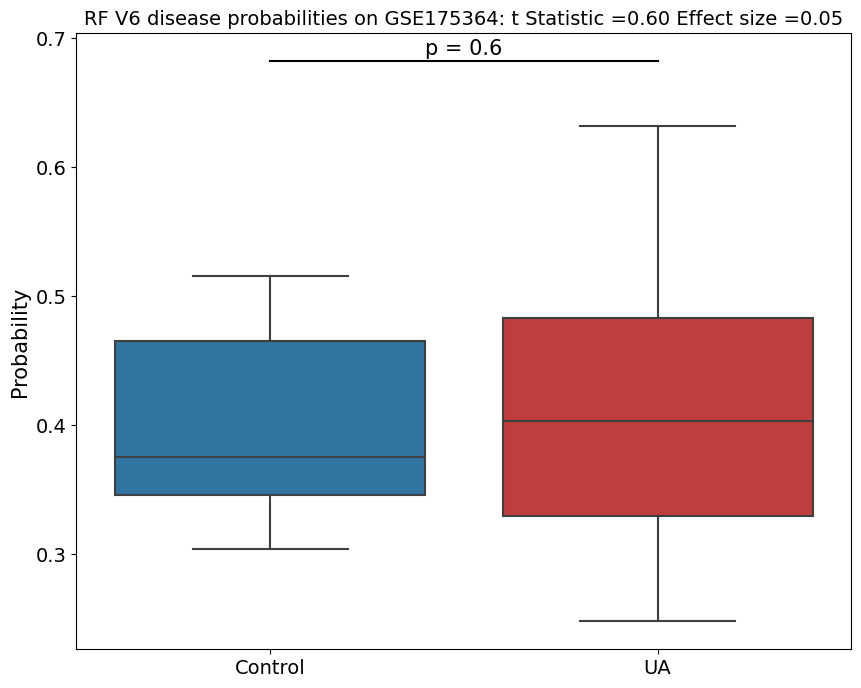

In [775]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

conditions=['Control', 'UA']

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=art2_meta, x='disease_state_init', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V6 disease probabilities on {}: t Statistic ={:.2f} Effect size ={:.2f}'.format(art2_meta.series_id[0],statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.05, max(d_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.savefig('Models/random_forests/V6/V6 RF disease probabilities undifferentiated arthritis.png',dpi=300)

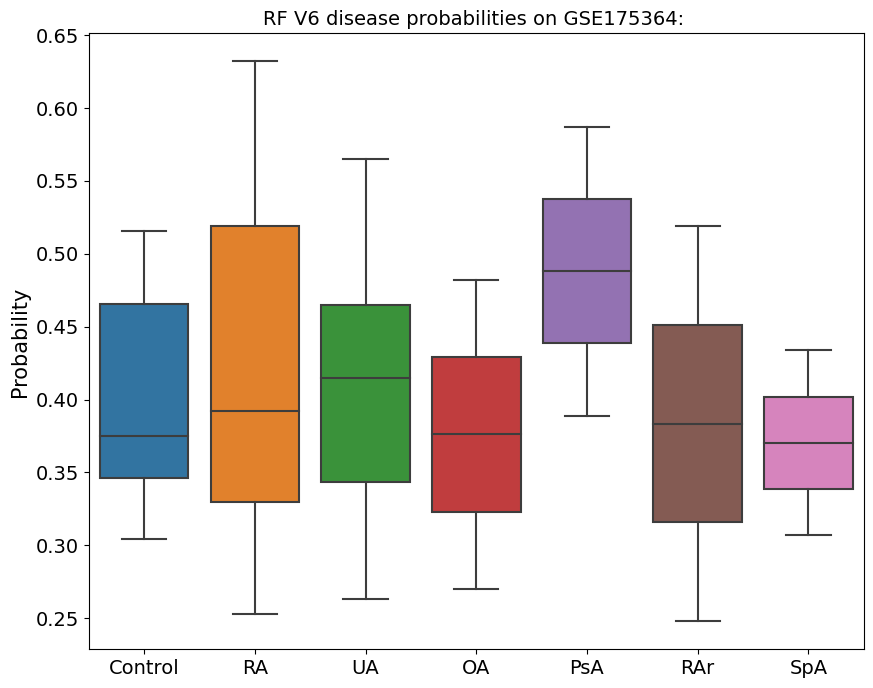

In [505]:
plt.figure(figsize=(10, 8)) 


custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=art2_meta, x='disease_state_yr1', y='v6 disease_prob')
plt.title('RF V6 disease probabilities on {}: '.format(art2_meta.series_id[0]),fontsize=14)


plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Models/random_forests/V6/V6 RF disease probabilities undifferentiated arthritis yr1.png',dpi=300)

<AxesSubplot: xlabel='age', ylabel='v6 disease_prob'>

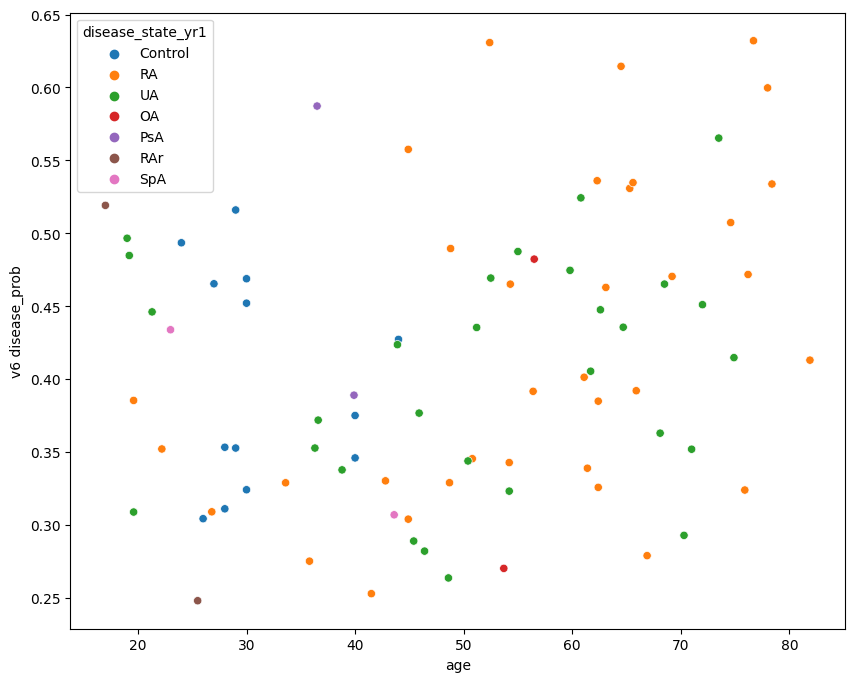

In [508]:
plt.figure(figsize=(10, 8)) 
sns.scatterplot(data=art2_meta, x = 'age', y='v6 disease_prob', hue = 'disease_state_yr1')

In [23]:
preds = clf.predict(park.values)
probs = clf.predict_proba(park.values)
get_accuracy(preds, park_meta.healthy)

dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
park_meta['v6 preds'] = preds
park_meta['v6 disease_prob'] = dis
park_meta['v6 health_prob'] = health

from scipy.stats import mannwhitneyu
h_probs = park_meta[park_meta.healthy==0]['v6 disease_prob']
d_probs = park_meta[park_meta.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U park
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size = cohens_d(h_probs, d_probs)

In [25]:
park_meta.to_excel('Datasets/Parkinsons Horvath/Parkinsons_pmeta.xlsx')

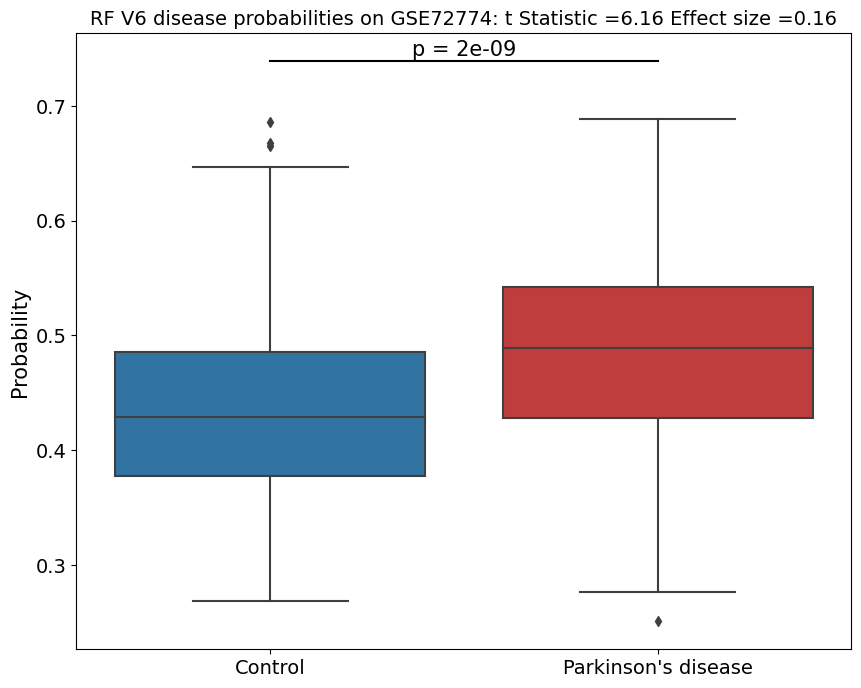

In [24]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

conditions=['Control', 'Parkinson\'s disease']

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=park_meta, x='disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V6 disease probabilities on {}: t Statistic ={:.2f} Effect size ={:.2f}'.format(park_meta.series_id[0],statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.05, max(d_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
# plt.savefig('Models/random_forests/V6/V6 RF disease probabilities Parkinsons (Horvath).png',dpi=300)

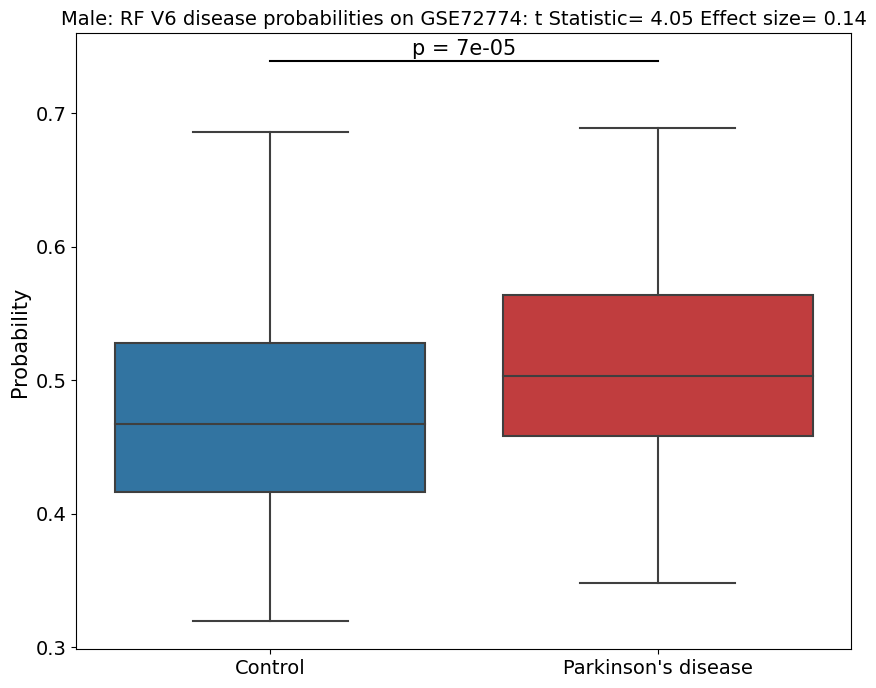

In [778]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

park_meta_m = park_meta[park_meta.gender=='Male']

h_probs = park_meta_m[park_meta_m.healthy==0]['v6 disease_prob']
d_probs = park_meta_m[park_meta_m.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U park
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size = cohens_d(h_probs, d_probs)

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=park_meta_m, x='disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('Male: RF V6 disease probabilities on {}: t Statistic= {:.2f} Effect size= {:.2f}'.format(park_meta.series_id[0], statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.05, max(d_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.savefig('Models/random_forests/V6/V6 RF disease probabilities parkinsons (Horvath) male.png',dpi=300)

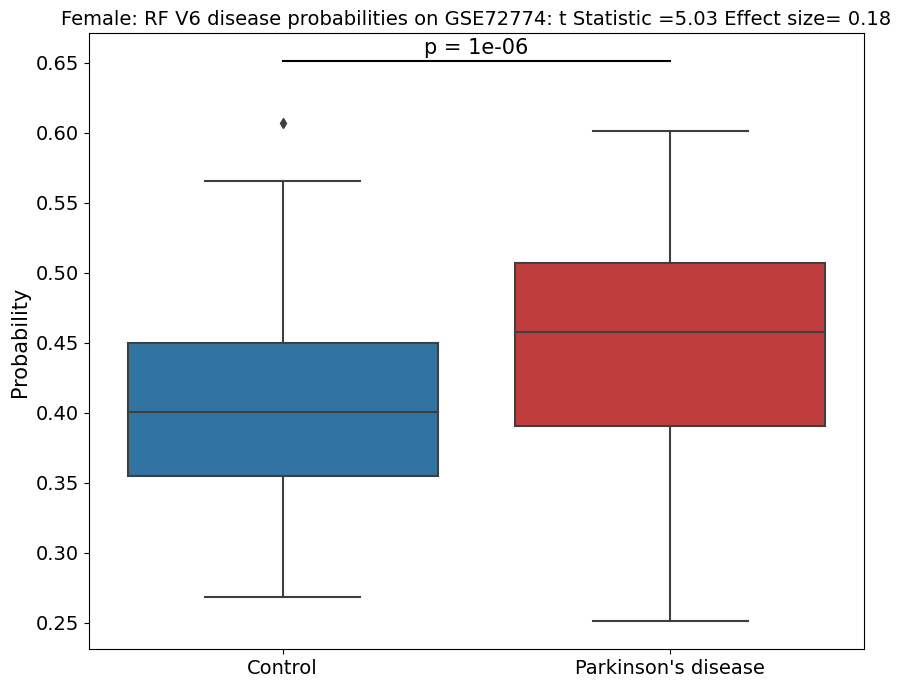

In [779]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

park_meta_f = park_meta[park_meta.gender=='Female']

h_probs = park_meta_f[park_meta_f.healthy==0]['v6 disease_prob']
d_probs = park_meta_f[park_meta_f.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U park
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size = cohens_d(h_probs,d_probs)

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=park_meta_f, x='disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('Female: RF V6 disease probabilities on {}: t Statistic ={:.2f} Effect size= {:.2f}'.format(park_meta.series_id[0],statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.05, max(d_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.savefig('Models/random_forests/V6/V6 RF disease probabilities parkinsons (Horvath) female.png',dpi=300)

<AxesSubplot: xlabel='age', ylabel='v6 disease_prob'>

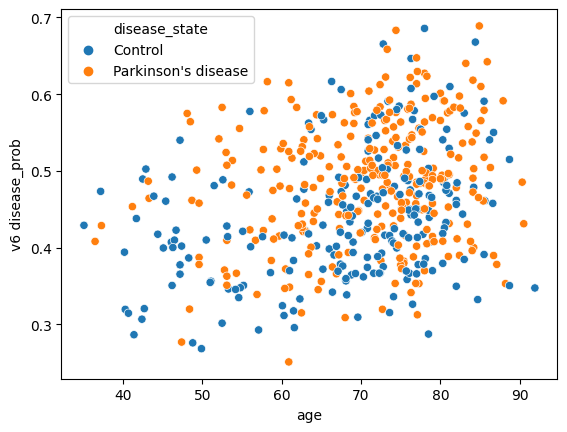

In [602]:
sns.scatterplot(data=park_meta, x = 'age', y='v6 disease_prob', hue = 'disease_state')

In [26]:
preds = clf.predict(ms.values)
probs = clf.predict_proba(ms.values)
get_accuracy(preds, ms_meta.healthy)

dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
ms_meta['v6 preds'] = preds
ms_meta['v6 disease_prob'] = dis
ms_meta['v6 health_prob'] = health

from scipy.stats import mannwhitneyu
h_probs = ms_meta[ms_meta.healthy==0]['v6 disease_prob']
d_probs = ms_meta[ms_meta.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U test
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size = cohens_d(h_probs, d_probs)

In [29]:
ms_meta

Unnamed: 0  age  gender smoking_status disease_state  healthy  series_id  \
0    GSM2844230   27    Male   never smoker       MS case        1  GSE106648   
1    GSM2844231   22    Male         smoker       MS case        1  GSE106648   
2    GSM2844232   40    Male         smoker       MS case        1  GSE106648   
3    GSM2844233   55    Male         smoker       MS case        1  GSE106648   
4    GSM2844234   43  Female   never smoker       MS case        1  GSE106648   
..          ...  ...     ...            ...           ...      ...        ...   
274  GSM2844550   37  Female         smoker       Control        0  GSE106648   
275  GSM2844551   48  Female   never smoker       MS case        1  GSE106648   
276  GSM2844552   23  Female         smoker       MS case        1  GSE106648   
277  GSM2844553   54  Female         smoker       Control        0  GSE106648   
278  GSM2844554   46  Female   never smoker       Control        0  GSE106648   

     v5 preds  v5 disease_prob  v5 health_prob  v4 preds  v4 disease_prob  \
0           0         0.474728        0.525272         0         0.486347   
1           1         0.506272        0.493728         1         0.531362   
2           0         0.482781        0.517219         0         0.492950   
3           0         0.487920        0.512080         1         0.524701   
4           0         0.464874        0.535126         0         0.486347   
..        ...              ...             ...       ...              ...   
274         0         0.475052        0.524948         0         0.486347   
275         0         0.485216        0.514784         0         0.496891   
276         0         0.478960        0.521040         0         0.488658   
277         0         0.478345        0.521655         0         0.488658   
278         0         0.467757        0.532243         0         0.490635   

     v4 health_prob  v6 preds  v6 disease_prob  v6 health_prob  
0          0.513653         0         0.314140        0.685860  
1          0.468638         0         0.370834        0.629166  
2          0.507050         0         0.368214        0.631786  
3          0.475299         0         0.335263        0.664737  
4          0.513653         0         0.285790        0.714210  
..              ...       ...              ...             ...  
274        0.513653         0         0.314105        0.685895  
275        0.503109         0         0.277691        0.722309  
276        0.511342         0         0.289488        0.710512  
277        0.511342         0         0.296172        0.703828  
278        0.509365         0         0.290001        0.709999  

[279 rows x 16 columns]

In [30]:
ms_meta.to_excel('Datasets/MS/MS_pmeta.xlsx')

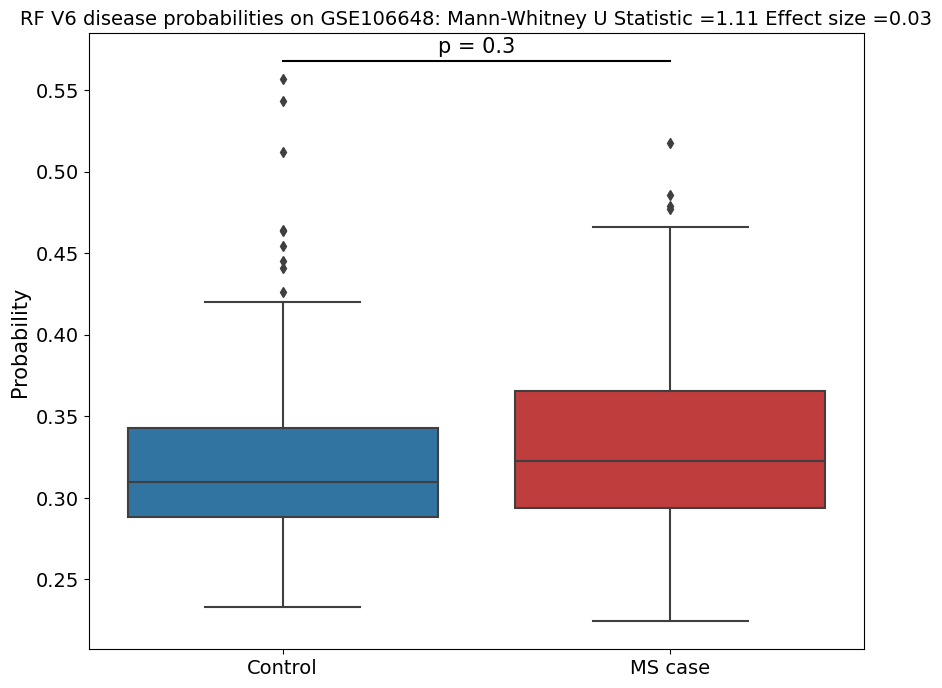

In [27]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

conditions=['Control', 'MS case']

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=ms_meta, x='disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V6 disease probabilities on {}: Mann-Whitney U Statistic ={:.2f} Effect size ={:.2f}'.format(ms_meta.series_id[0],statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.05, max(d_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
# plt.savefig('Models/random_forests/V6/V6 RF disease probabilities MS.png',dpi=300)

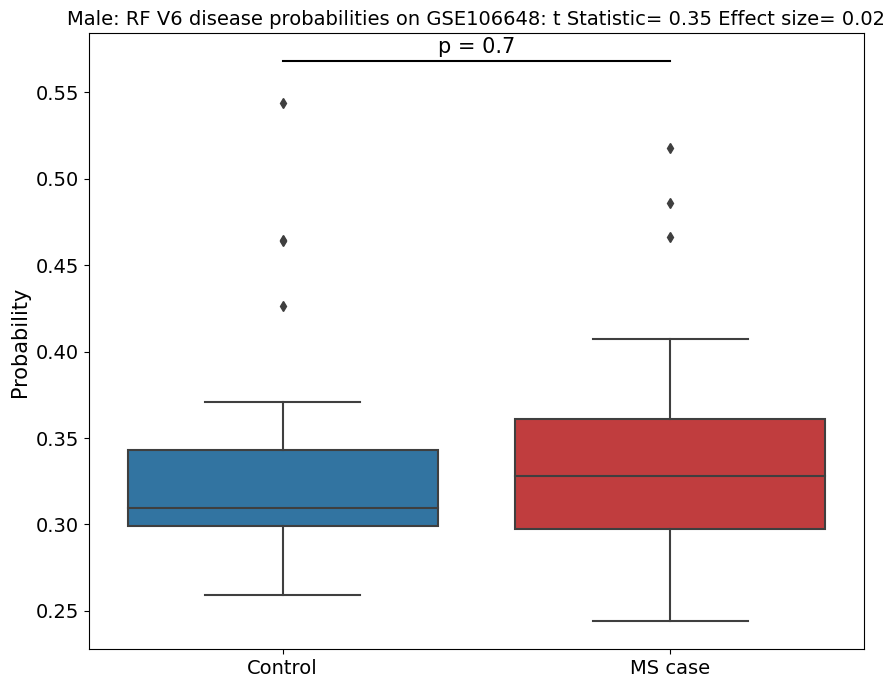

In [782]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

ms_meta_m = ms_meta[ms_meta.gender=='Male']

h_probs = ms_meta_m[ms_meta_m.healthy==0]['v6 disease_prob']
d_probs = ms_meta_m[ms_meta_m.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U ms
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size = cohens_d(h_probs, d_probs)

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=ms_meta_m, x='disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('Male: RF V6 disease probabilities on {}: t Statistic= {:.2f} Effect size= {:.2f}'.format(ms_meta.series_id[0], statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.05, max(d_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

# plt.savefig('Models/random_forests/V6/V6 RF disease probabilities MS male.png',dpi=300)

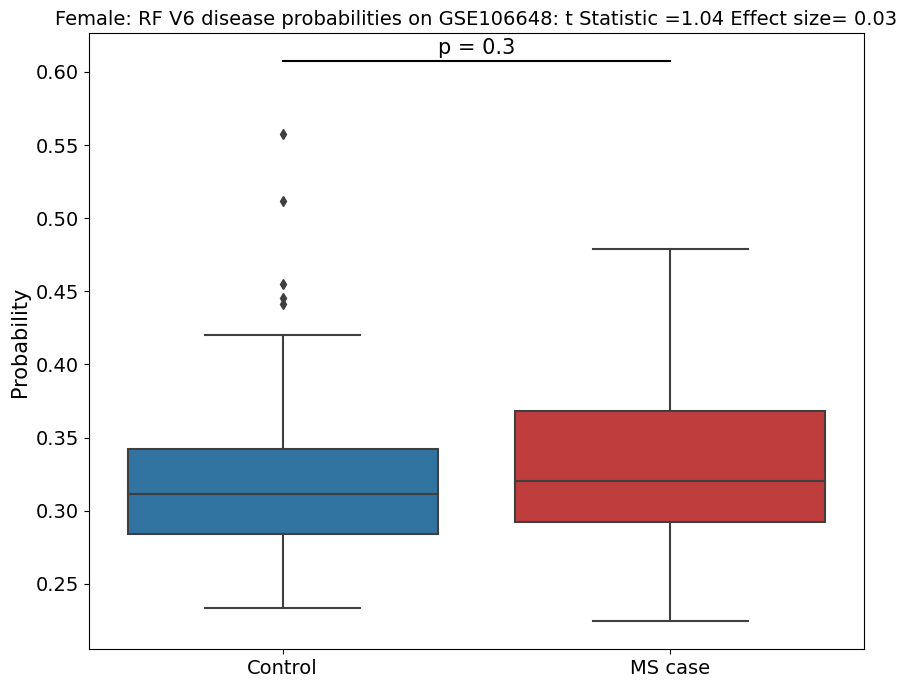

In [784]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

ms_meta_f = ms_meta[ms_meta.gender=='Female']

h_probs = ms_meta_f[ms_meta_f.healthy==0]['v6 disease_prob']
d_probs = ms_meta_f[ms_meta_f.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U ms
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size = cohens_d(h_probs,d_probs)

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=ms_meta_f, x='disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('Female: RF V6 disease probabilities on {}: t Statistic ={:.2f} Effect size= {:.2f}'.format(ms_meta.series_id[0],statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(h_probs) + 0.05, max(h_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(h_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.savefig('Models/random_forests/V6/V6 RF disease probabilities MS female.png',dpi=300)

<AxesSubplot: xlabel='age', ylabel='v6 disease_prob'>

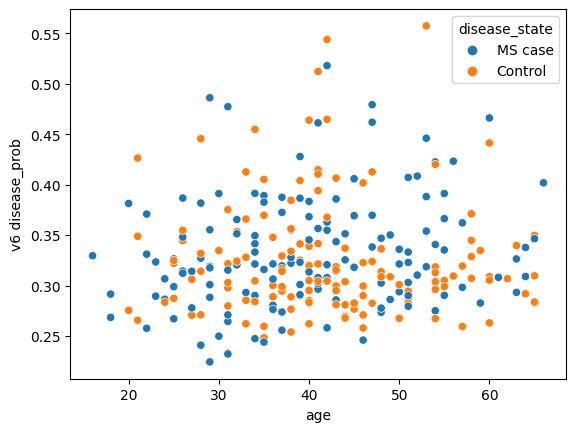

In [615]:
sns.scatterplot(data=ms_meta, x = 'age', y='v6 disease_prob', hue = 'disease_state')

In [31]:
preds = clf.predict(dep.values)
probs = clf.predict_proba(dep.values)
get_accuracy(preds, dep_meta.healthy)

dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
dep_meta['v6 preds'] = preds
dep_meta['v6 disease_prob'] = dis
dep_meta['v6 health_prob'] = health

from scipy.stats import mannwhitneyu
h_probs = dep_meta[dep_meta.healthy==0]['v6 disease_prob']
d_probs = dep_meta[dep_meta.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U dep
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var = True)
effect_size = cohens_d(h_probs, d_probs)

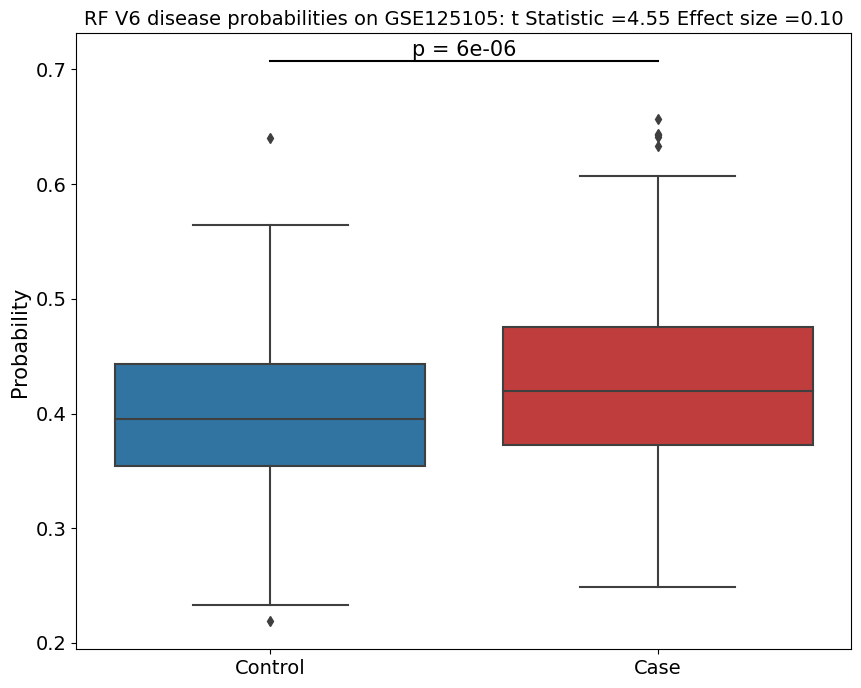

In [32]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

conditions=['Control', 'Case']

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=dep_meta, x='disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V6 disease probabilities on {}: t Statistic ={:.2f} Effect size ={:.2f}'
          .format(dep_meta.series_id[0],statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.05, max(d_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Models/random_forests/V6/V6 RF disease probabilities depression.png',dpi=300)

In [33]:
dep_meta.to_excel('Datasets/Depression/Depression_pmeta.xlsx')

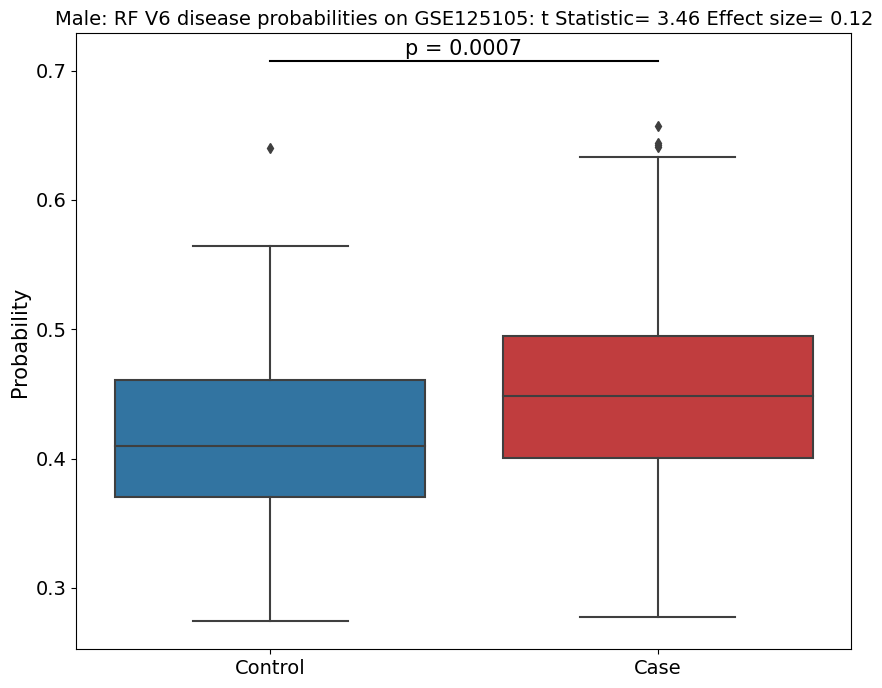

In [788]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

dep_meta_m = dep_meta[dep_meta.gendeer=='Male']

h_probs = dep_meta_m[dep_meta_m.healthy==0]['v6 disease_prob']
d_probs = dep_meta_m[dep_meta_m.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U dep
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size = cohens_d(h_probs, d_probs)

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=dep_meta_m, x='disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('Male: RF V6 disease probabilities on {}: t Statistic= {:.2f} Effect size= {:.2f}'.format(dep_meta.series_id[0], statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.05, max(d_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.savefig('Models/random_forests/V6/V6 RF disease probabilities Depression male.png',dpi=300)

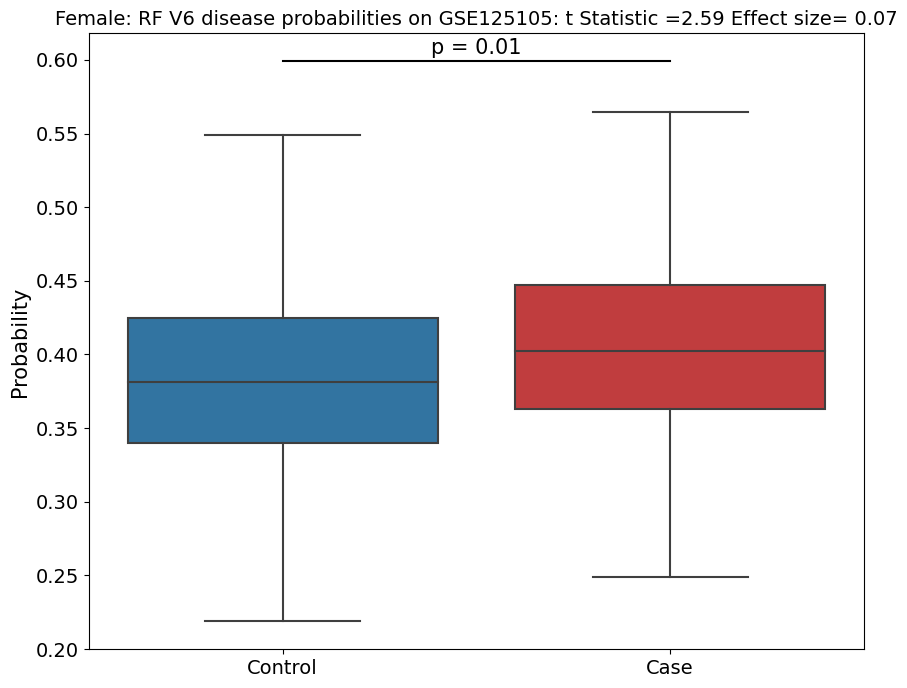

In [789]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

dep_meta_f = dep_meta[dep_meta.gendeer=='Female']

h_probs = dep_meta_f[dep_meta_f.healthy==0]['v6 disease_prob']
d_probs = dep_meta_f[dep_meta_f.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U dep
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size = cohens_d(h_probs,d_probs)

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=dep_meta_f, x='disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('Female: RF V6 disease probabilities on {}: t Statistic ={:.2f} Effect size= {:.2f}'.format(dep_meta.series_id[0],statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(h_probs) + 0.05, max(h_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(h_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.savefig('Models/random_forests/V6/V6 RF disease probabilities Depression female.png',dpi=300)

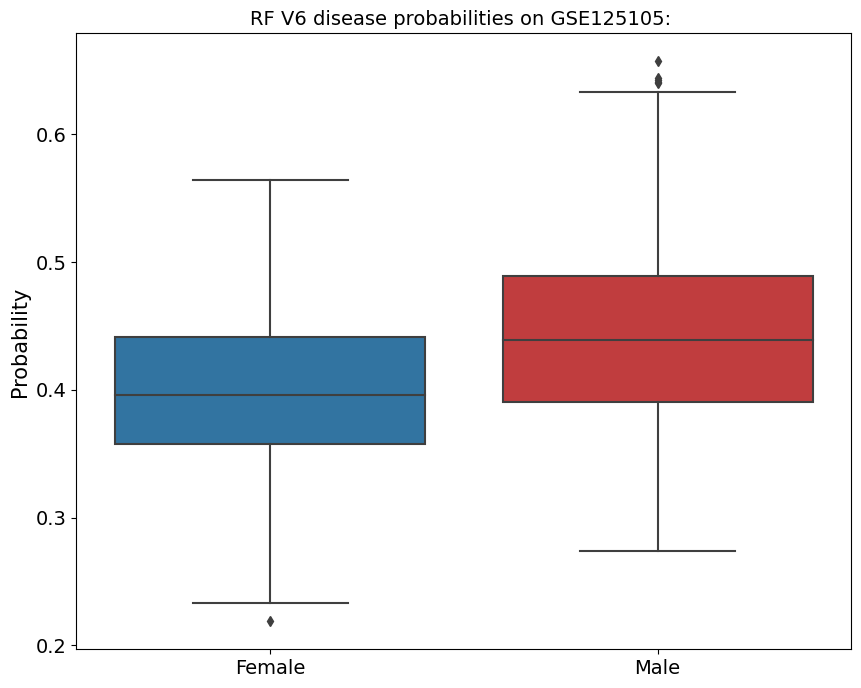

In [628]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

conditions=['Female', 'Male']

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=dep_meta, x='gendeer', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V6 disease probabilities on {}: '.format(dep_meta.series_id[0]),fontsize=14)
# Add significance bar and p-value

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
# plt.savefig('Models/random_forests/V6/V6 RF disease probabilities depression.png',dpi=300)

<AxesSubplot: xlabel='age', ylabel='v6 disease_prob'>

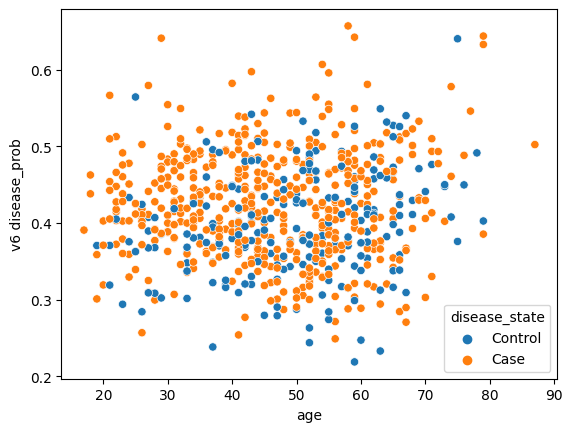

In [623]:
sns.scatterplot(data=dep_meta, x = 'age', y='v6 disease_prob', hue = 'disease_state')

In [34]:
preds = clf.predict(tau.values)
probs = clf.predict_proba(tau.values)
get_accuracy(preds, tau_meta.healthy)

dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
tau_meta['v6 preds'] = preds
tau_meta['v6 disease_prob'] = dis
tau_meta['v6 health_prob'] = health

from scipy.stats import mannwhitneyu
h_probs = tau_meta[tau_meta.healthy==0]['v6 disease_prob']
d_probs = tau_meta[tau_meta.healthy==1]['v6 disease_prob']
# Perform the Mann-Whitney U tau
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)
effect_size=cohens_d(h_probs, d_probs)

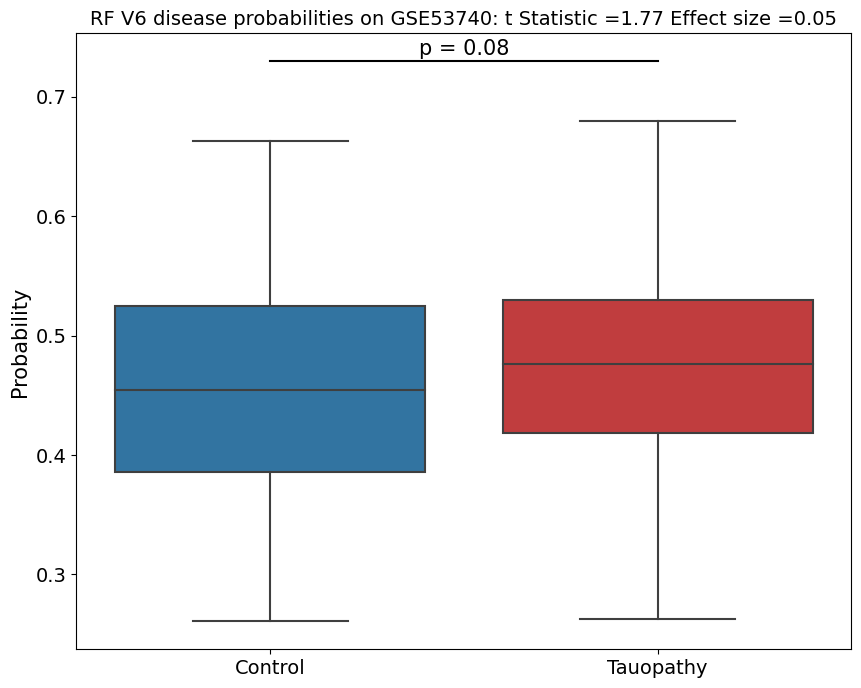

In [35]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

conditions=['Control', 'Tauopathy']

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=tau_meta, x='simple_disease_state', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V6 disease probabilities on {}: t Statistic ={:.2f} Effect size ={:.2f}'
          .format(tau_meta.series_id[0],statistic, effect_size),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.05, max(d_probs) + 0.05], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.savefig('Models/random_forests/V6/V6 RF disease probabilities Tauopathy.png',dpi=300)

In [36]:
tau_meta.to_excel('Datasets/Tauopathy/Tauopathy_pmeta.xlsx')

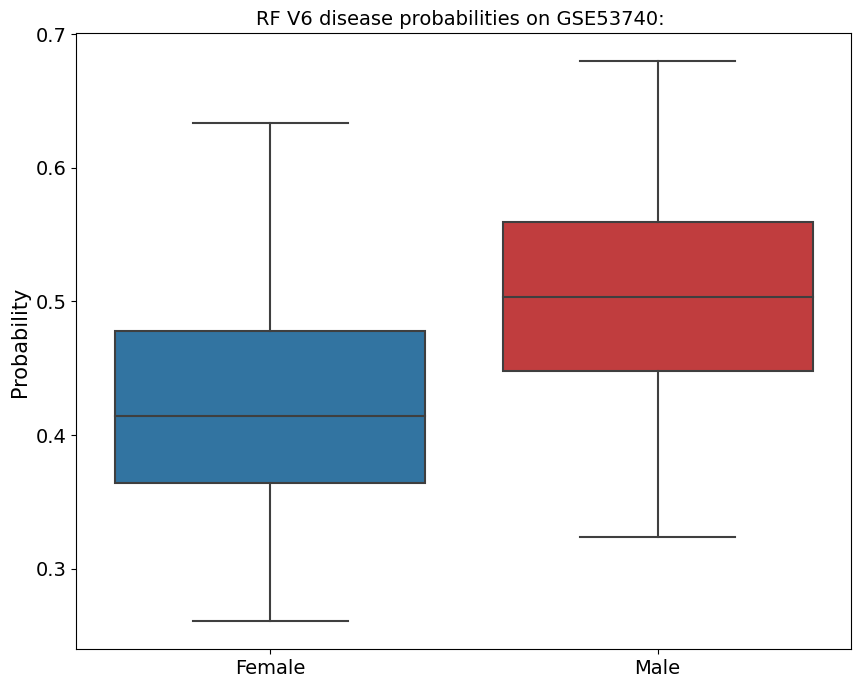

In [631]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

conditions=['Female', 'Male']

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=tau_meta, x='gender', y='v6 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V6 disease probabilities on {}: '.format(tau_meta.series_id[0]),fontsize=14)
# Add significance bar and p-value

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
# plt.savefig('Models/random_forests/V6/V6 RF disease probabilities tauression.png',dpi=300)

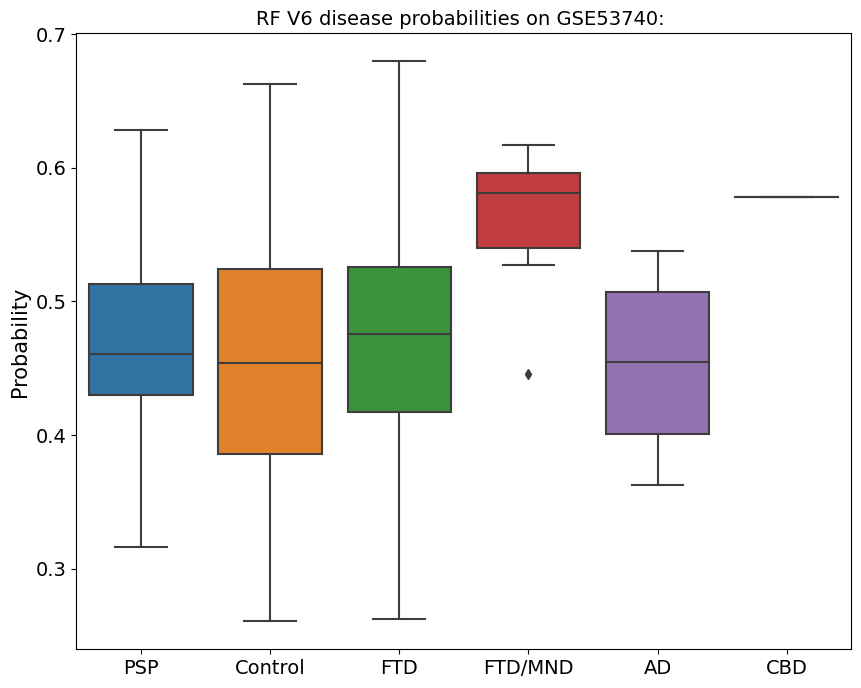

In [520]:
plt.figure(figsize=(10, 8)) 



sns.boxplot(data=tau_meta, x='disease_state', y='v6 disease_prob')
plt.title('RF V6 disease probabilities on {}: '.format(tau_meta.series_id[0]),fontsize=14)


plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Models/random_forests/V6/V6 RF disease probabilities Tauopathy detailed.png',dpi=300)

<AxesSubplot: xlabel='age', ylabel='v6 disease_prob'>

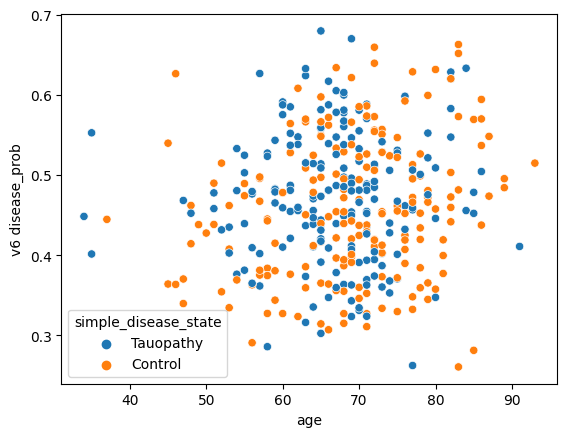

In [488]:
sns.scatterplot(data=tau_meta, x = 'age', y='v6 disease_prob', hue = 'simple_disease_state')

<AxesSubplot: xlabel='age', ylabel='v6 disease_prob'>

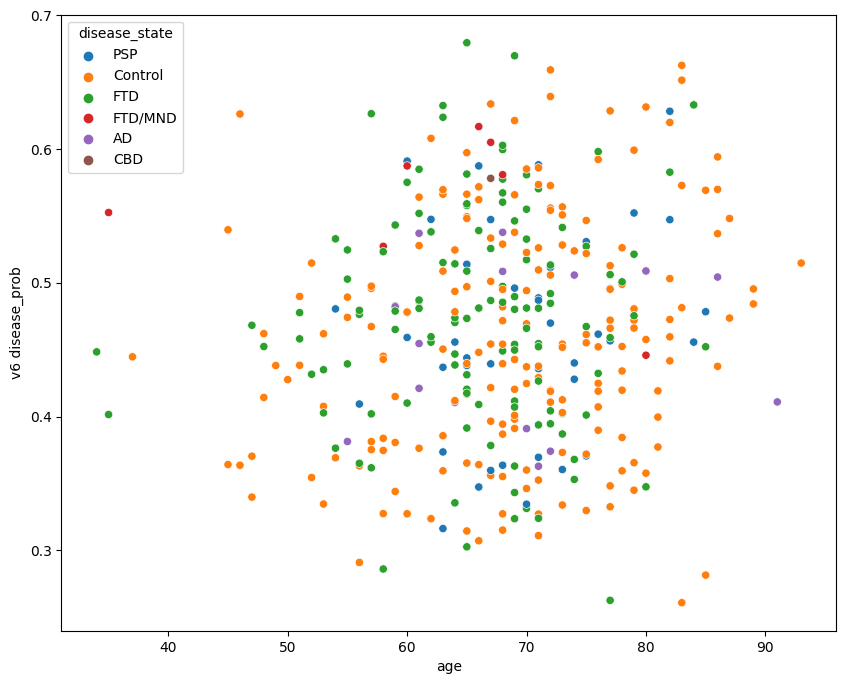

In [522]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=tau_meta, x = 'age', y='v6 disease_prob', hue = 'disease_state')

## Alzheimers no MCI

In [7]:
file_path='Datasets/Alzheimers/'
alz = np.load(file_path+'No_mci.npy', allow_pickle=True)
alz_meta = pd.read_excel(file_path+'No_mci_meta.xlsx')
cgs = list_reader(file_path+'cgs.txt')
alz_df = pd.DataFrame(alz, columns=cgs)

In [45]:
alz_importances = get_mi(alz_df,alz_meta.healthy,file_path)

In [9]:
imps = pd.read_excel(file_path+'MI_cgs.xlsx')

## Alzheimers w/ MCI

In [8]:
file_path='Datasets/Alzheimers/'
alz = np.load(file_path+'Alzheimers.npy', allow_pickle=True)
alz_meta = pd.read_excel(file_path+'Alzheimers_pmeta.xlsx')
cgs = list_reader(file_path+'cgs.txt')
alz_df = pd.DataFrame(alz, columns=cgs)

In [9]:
alz_importances = get_mi(alz_df,alz_meta.healthy,file_path)

## Depression

In [290]:
file_path='Datasets/Depression/'
dep = np.load(file_path+'Depression_full.npy', allow_pickle=True)
dep_meta = pd.read_excel(file_path+'Depression_pmeta.xlsx')
cgs = list_reader(file_path+'cgs_full.txt')
dep_df = pd.DataFrame(dep, columns=cgs)

In [6]:
dep_importances = get_mi(dep_df,dep_meta.healthy,file_path)

## Pagets

In [6]:
file_path='Datasets/Pagets/'
pag = np.load(file_path+'Pagets.npy', allow_pickle=True)
pag_meta = pd.read_excel(file_path+'Pagets_pmeta.xlsx')
cgs = list_reader(file_path+'cgs.txt')
pag_df = pd.DataFrame(pag, columns=cgs)

In [7]:
pag_importances = get_mi(pag_df,pag_meta.healthy,file_path)

## Parkinsons Vallerga

In [5]:
file_path='Datasets/Parkinsons Vallerga/'
park = np.load(file_path+'Parkinsons.npy', allow_pickle=True)
park_meta = pd.read_excel(file_path+'Parkinsons_Vallerga_pmeta.xlsx')
cgs = list_reader(file_path+'cgs.txt')
park_df = pd.DataFrame(park, columns=cgs)

In [6]:
park_importances = get_mi(park_df,park_meta.healthy,file_path)

## PESA

In [5]:
file_path='Datasets/PESA/'
pesa = np.load(file_path+'PESA.npy', allow_pickle=True)
pesa_meta = pd.read_excel(file_path+'PESA_pmeta.xlsx')
cgs = list_reader(file_path+'cgs.txt')
pesa_df = pd.DataFrame(pesa, columns=cgs)

In [6]:
pesa_importances = get_mi(pesa_df,pesa_meta.healthy,file_path)

## Obesity2

In [5]:
file_path='Datasets/Obesity2/'
obs = np.load(file_path+'Obesity2.npy', allow_pickle=True)
obs_meta = pd.read_excel(file_path+'Obesity2_pmeta.xlsx')
cgs = list_reader(file_path+'cgs.txt')
obs_df = pd.DataFrame(obs, columns=cgs)

In [6]:
obs_importances = get_mi(obs_df,obs_meta.healthy,file_path)

## Arthritis

In [5]:
file_path='Datasets/Arthritis/'
art = np.load(file_path+'Arthritis.npy', allow_pickle=True)
art_meta = pd.read_excel(file_path+'Arthritis_pmeta.xlsx')
cgs = list_reader(file_path+'cgs.txt')
art_df = pd.DataFrame(art, columns=cgs)

In [25]:
art_importances = get_mi(art_df,art_meta.healthy,file_path)

In [27]:
conditions = ('Normal','Rheumatoid arthritis')

## Train RF/XGBoost model on Combined V4

In [426]:
# data = np.load('Datasets/Combined/RF/V4/V4 combined.npy', allow_pickle=True)
# meta = pd.read_excel('Datasets/Combined/RF/V4/V4_combined_pmeta.xlsx')
v4_cgs = list_reader('Datasets/Combined/RF/V4/V4 combined cgs.txt')

In [8]:
df = pd.DataFrame(data, columns=cgs)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(df[df.columns[:]], meta, test_size=0.15, random_state=1)

In [10]:
estimators =[
        ('clf', XGBClassifier(n_jobs=-1, random_state=1))
]

pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=1, ...))])

In [366]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer 

search_space = {
    
    'clf__n_estimators': Integer(25,50),
    'clf__max_depth': Integer(1,4),
    'clf__grow_policy': Categorical(['lossguide']),
    'clf__learning_rate': Real(0.001, 5.0, prior='log-uniform'),
    'clf__subsample': Real(0.0,1.0),
    'clf__colsample_bytree': Real(0.0,1.0),
    'clf__colsample_bylevel': Real(0.0,1.0),
    'clf__colsample_bynode': Real(0.0,1.0),
    'clf__reg_alpha': Real(0.0,10.0),
    'clf__reg_lambda': Real(0.0,10.0),
    'clf__gamma': Real(0.0,10.0)
}
opt = BayesSearchCV(pipe, search_space, cv = 5, n_iter=10, scoring = 'roc_auc',  random_state=8)

In [367]:
opt.fit(x_train.values, y_train.healthy)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=None,
                                                       interaction_constraints=...
                             'clf__min_child_weight': Real(low=0, high=10, prior='uniform', transform='normalize'),
                             'clf__n_estimators': Integer(low=25, high=100, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=20.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=20.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.0, high=1.0, prior='uniform', transform='normalize')})

In [368]:
print(opt.best_estimator_)

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.32693344075255665,
                               colsample_bynode=0.9764204617578107,
                               colsample_bytree=0.8024126604159503, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=2.0074616598796236,
                               grow_policy='lossguide', importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.035222916758012264, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None,
                               min_child_weight=8.691438

In [843]:
print("Best Parameters: ", opt.best_params_)

Best Parameters:  OrderedDict([('clf__colsample_bylevel', 0.7160044460033754), ('clf__colsample_bynode', 0.5634842539270097), ('clf__colsample_bytree', 0.8894150401192538), ('clf__gamma', 0.12840880628708476), ('clf__grow_policy', 'lossguide'), ('clf__learning_rate', 0.00568163850830219), ('clf__max_depth', 4), ('clf__n_estimators', 48), ('clf__reg_alpha', 4.798723053001591), ('clf__reg_lambda', 2.4605716594368947), ('clf__subsample', 0.9780414416994725)])


In [370]:
opt.best_score_

0.7357470253429161

In [371]:
opt.score(park.values, park_meta.healthy)

0.6766996887393153

In [737]:
#V4 model params
clf = xgb.XGBClassifier(n_estimators=30, booster='gbtree', max_depth=1, 
                        subsample=0.65, tree_method='auto', grow_policy='lossguide', 
                        eta=0.001, learning_rate=0.0082, n_jobs=-1, objective='binary:logistic')

In [395]:
#This is the V5 model
clf = xgb.XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7160044460033754,
              colsample_bynode=0.5634842539270097,
              colsample_bytree=0.8894150401192538, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.12840880628708476,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.00568163850830219,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, monotone_constraints=None,
              multi_strategy=None, n_estimators=48, n_jobs=-1,objective='binary:logistic',
              num_parallel_tree=None, random_state=1, reg_alpha= 4.798723053001591, 
              reg_lambda=2.4605716594368947, subsample = 0.9780414416994725)

In [396]:
clf.fit(x_train.values,y_train.healthy)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7160044460033754,
              colsample_bynode=0.5634842539270097,
              colsample_bytree=0.8894150401192538, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.12840880628708476,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.00568163850830219,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=48, n_jobs=-1,
              num_parallel_tree=None, random_state=1, ...)

In [383]:
preds = clf.predict(x_val.values)

In [384]:
get_accuracy(preds, y_val.healthy)

(0.7136659436008677,
 (161, 83, 168, 49),
 (0.7666666666666667, 0.33067729083665337))

In [362]:
# selection = pd.DataFrame({'CpG': cgs, 'Importance':clf.feature_importances_})
# selection=selection[selection.Importance !=0]
# selection=selection.sort_values('Importance', axis=0, ascending=False)
# selection.to_excel('Models/random_forests/V5/V5_feature_selection.xlsx')
# selection

In [363]:
# joblib.dump(clf, 'Models/random_forests/V5/combinedV5.joblib')

In [401]:
clf=joblib.load('Models/random_forests/V5/combinedV5.joblib')

In [397]:
preds = clf.predict(park)
probs = clf.predict_proba(park)
get_accuracy(preds, park_meta.healthy)

(0.6692913385826772,
 (224, 103, 116, 65),
 (0.7750865051903114, 0.4703196347031963))

In [398]:
dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
park_meta['v5 preds'] = preds
park_meta['v5 disease_prob'] = dis
park_meta['v5 health_prob'] = health

In [403]:
from scipy.stats import mannwhitneyu
conditions = ('Control','Parkinson\'s disease')
h_probs = park_meta[park_meta.healthy==0]['v5 disease_prob']
d_probs = park_meta[park_meta.healthy==1]['v5 disease_prob']
# Perform the Mann-Whitney U park
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)

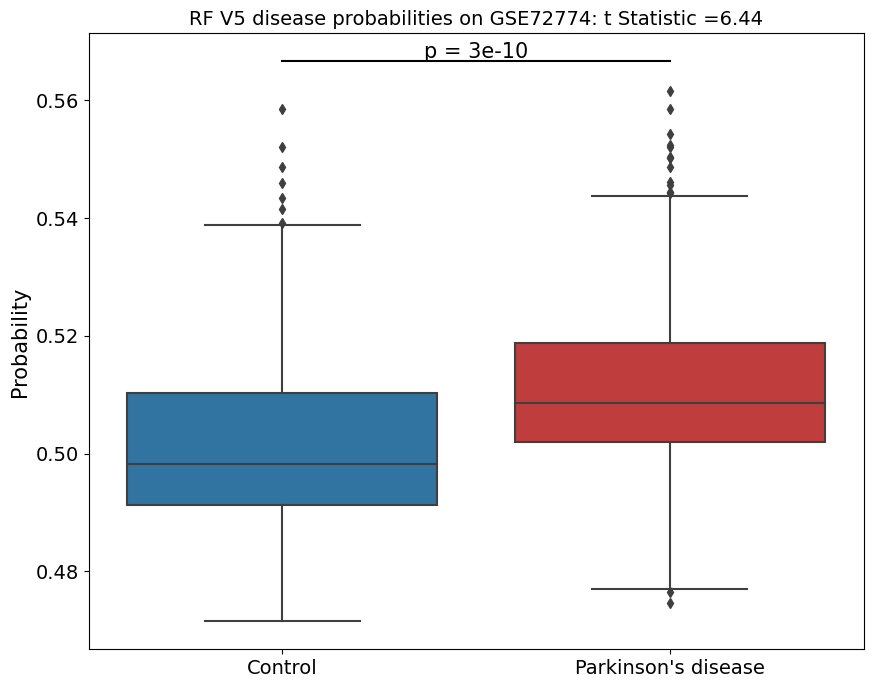

In [407]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=park_meta, x='disease_state', y='v5 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V5 disease probabilities on {}: t Statistic ={:.2f}'.format(park_meta.series_id[0],statistic),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.005, max(d_probs) + 0.005], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.0055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.savefig('Models/random_forests/V5/V5 RF disease probabilities Parkinsons.png',dpi=300)

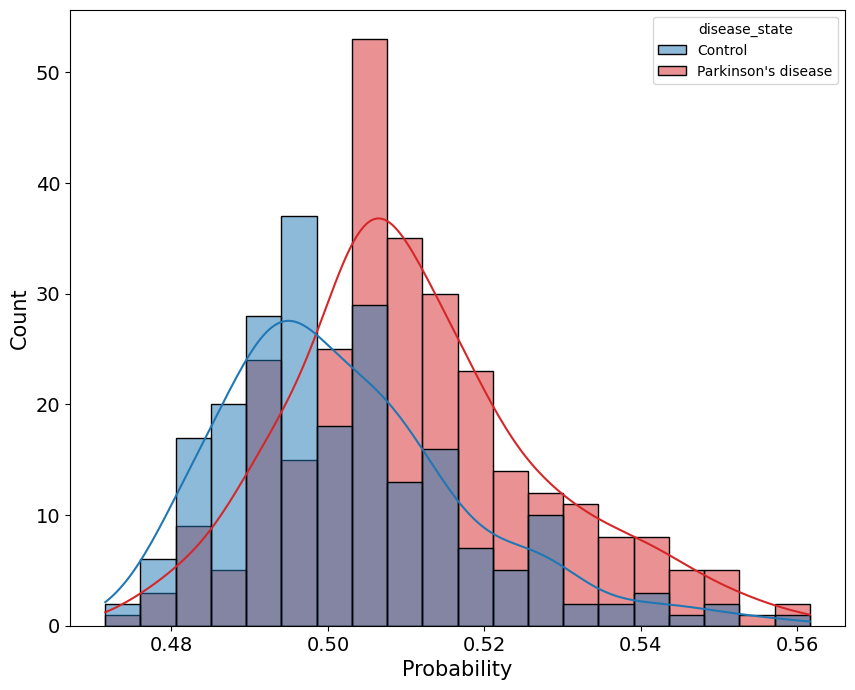

In [406]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
# Define the desired order of categories
sns.histplot( data=park_meta, x=park_meta['v5 disease_prob'], kde=True, bins=20, hue='disease_state', palette=custom_palette)

plt.xlabel('Probability',fontsize=15)
plt.ylabel('Count',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
# plt.savefig('Models/random_forests/V5/V5 RF disease probabilities hist Parkinsons.png',dpi=300)

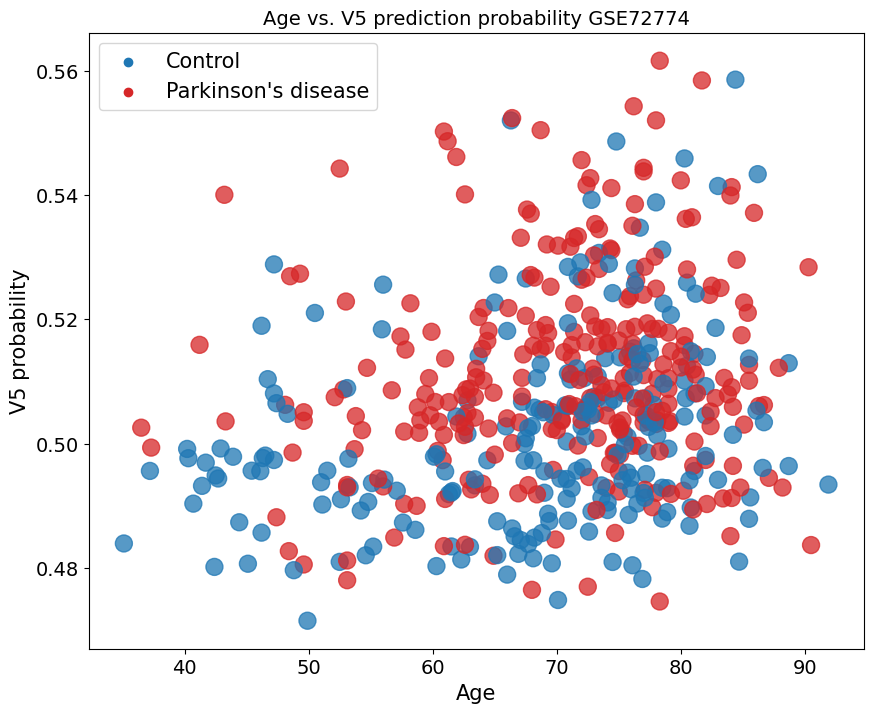

In [409]:
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(data=park_meta, x='age', y='v5 disease_prob',hue='disease_state', 
                                s=150, alpha=0.75, edgecolor="Face",palette=custom)

plt.xlabel('Age',fontsize=15)
plt.ylabel('V5 probability',fontsize=15)
plt.title('Age vs. V5 prediction probability {}'.format(park_meta.series_id[0]),fontsize=14)


plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.legend(loc='best', fontsize=15)
plt.savefig('Models/random_forests/V5/V5 RF disease probabilities scatter Parkinsons.png',dpi=300)

In [415]:
preds=clf.predict(ms.values)
probs = clf.predict_proba(ms.values)
get_accuracy(preds, ms_meta.healthy)

dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
ms_meta['v5 preds'] = preds
ms_meta['v5 disease_prob'] = dis
ms_meta['v5 health_prob'] = health

from scipy.stats import mannwhitneyu
conditions = ('Control','MS case')
h_probs = ms_meta[ms_meta.healthy==0]['v5 disease_prob']
d_probs = ms_meta[ms_meta.healthy==1]['v5 disease_prob']
# Perform the Mann-Whitney U test
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)

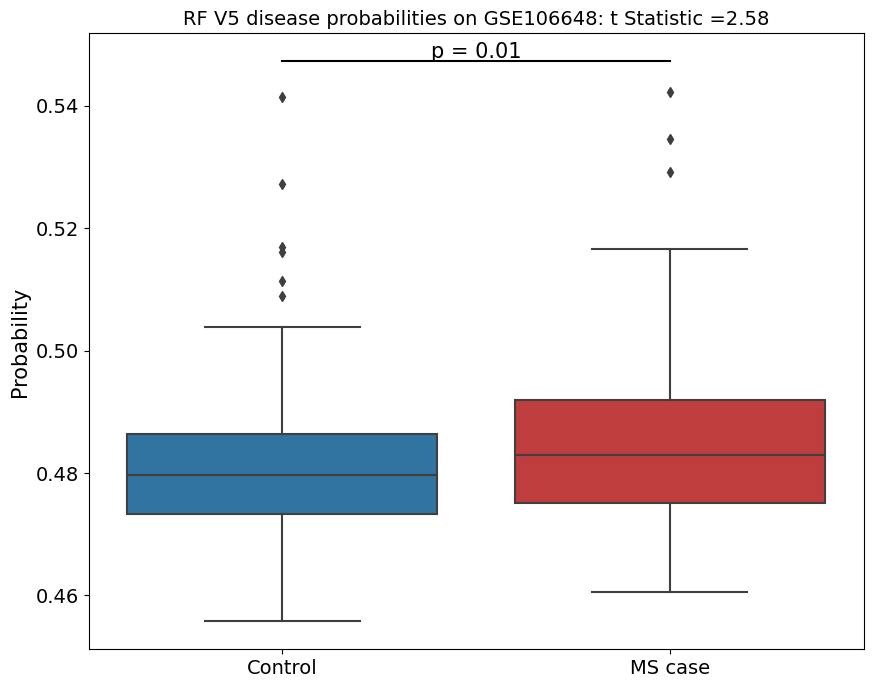

In [416]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=ms_meta, x='disease_state', y='v5 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V5 disease probabilities on {}: t Statistic ={:.2f}'.format(ms_meta.series_id[0],statistic, p_value),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.005, max(d_probs) + 0.005], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.0055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.savefig('Models/random_forests/V5/V5 RF disease probabilities MS.png',dpi=300)

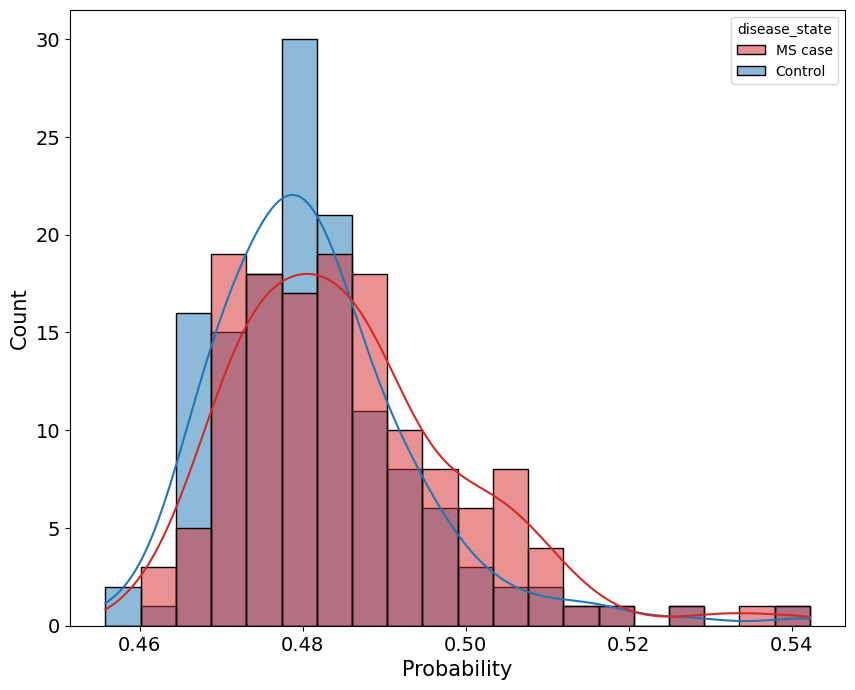

In [417]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
# Define the desired order of categories
sns.histplot( data=ms_meta, x=ms_meta['v5 disease_prob'], kde=True, bins=20, hue='disease_state', palette=custom_palette)

plt.xlabel('Probability',fontsize=15)
plt.ylabel('Count',fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Models/random_forests/V5/V5 RF disease probabilities hist MS.png',dpi=300)

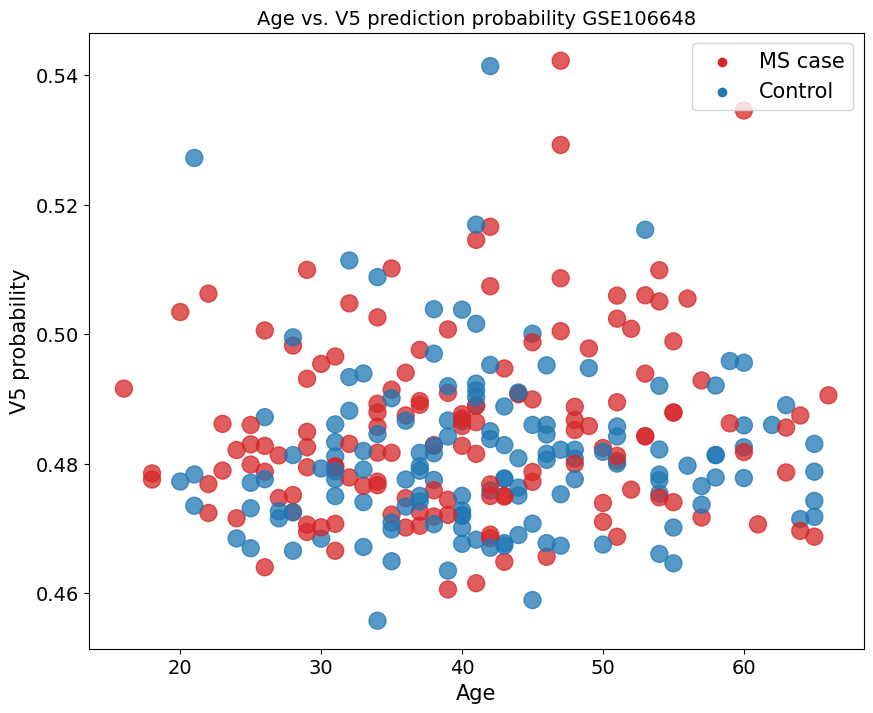

In [418]:
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(data=ms_meta, x='age', y='v5 disease_prob',hue='disease_state', 
                                s=150, alpha=0.75, edgecolor="Face",palette=custom)

plt.xlabel('Age',fontsize=15)
plt.ylabel('V5 probability',fontsize=15)
plt.title('Age vs. V5 prediction probability {}'.format(ms_meta.series_id[0]),fontsize=14)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=15)
plt.savefig('Models/random_forests/V5/V5 RF disease probabilities scatter MS.png',dpi=300)

In [419]:
preds = clf.predict(tau.values)
probs = clf.predict_proba(tau.values)
get_accuracy(preds, tau_meta.healthy)

dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
tau_meta['v5 preds'] = preds
tau_meta['v5 disease_prob'] = dis
tau_meta['v5 health_prob'] = health

conditions = ('Control','Tauopathy')
h_probs = tau_meta[tau_meta.healthy==0]['v5 disease_prob']
d_probs = tau_meta[tau_meta.healthy==1]['v5 disease_prob']
# Perform the Mann-Whitney U test
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)

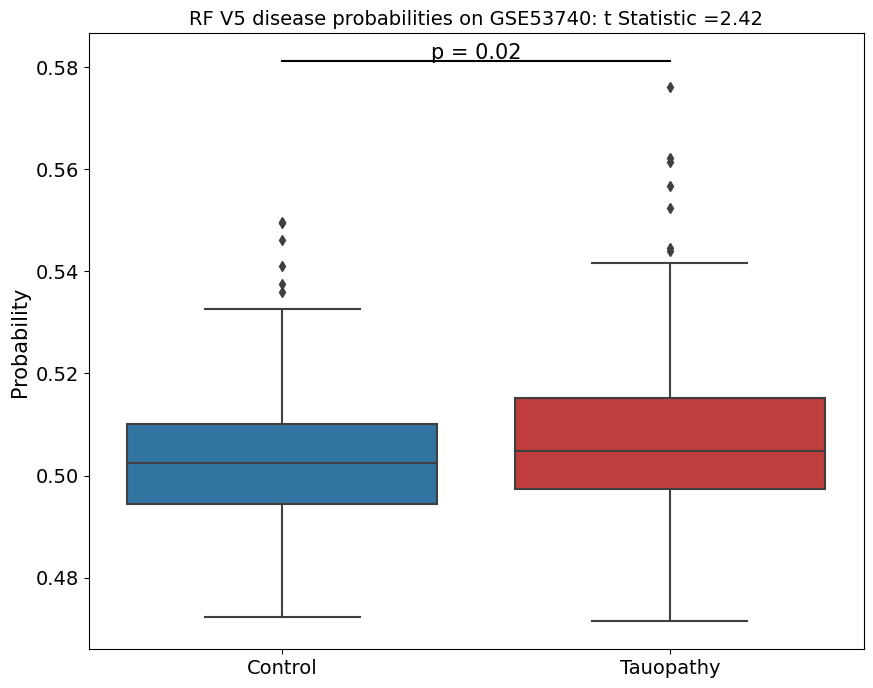

In [421]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=tau_meta, x='simple_disease_state', y='v5 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V5 disease probabilities on {}: t Statistic ={:.2f}'.format(tau_meta.series_id[0],statistic),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.005, max(d_probs) + 0.005], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.0055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.savefig('Models/random_forests/V5/V5 RF disease probabilities Tauopathy.png',dpi=300)

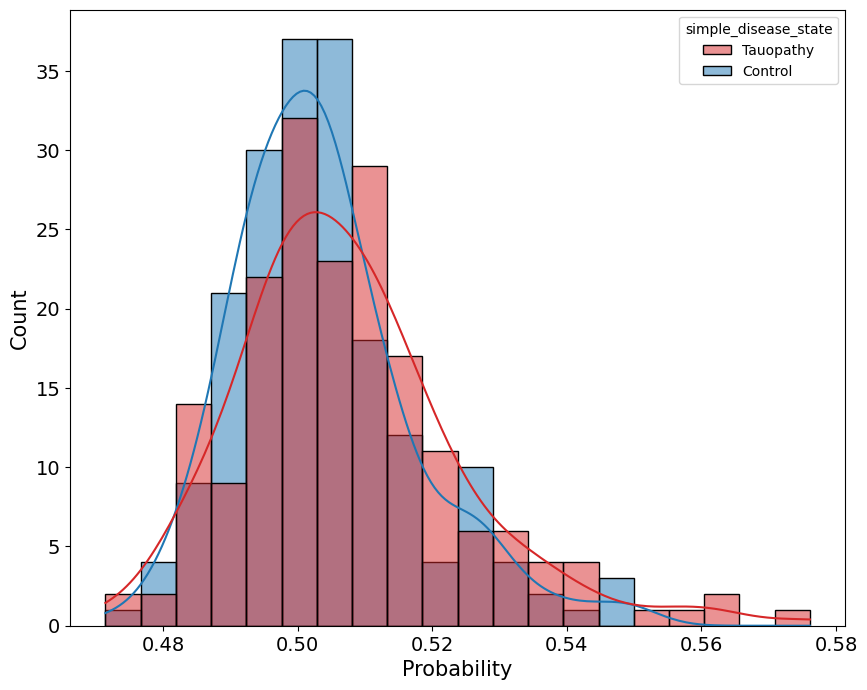

In [422]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
# Define the desired order of categories
sns.histplot( data=tau_meta, x=tau_meta['v5 disease_prob'], kde=True, bins=20, hue='simple_disease_state', palette=custom_palette)

plt.xlabel('Probability',fontsize=15)
plt.ylabel('Count',fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Models/random_forests/V5/V5 RF disease probabilities hist Tauopathy.png',dpi=300)

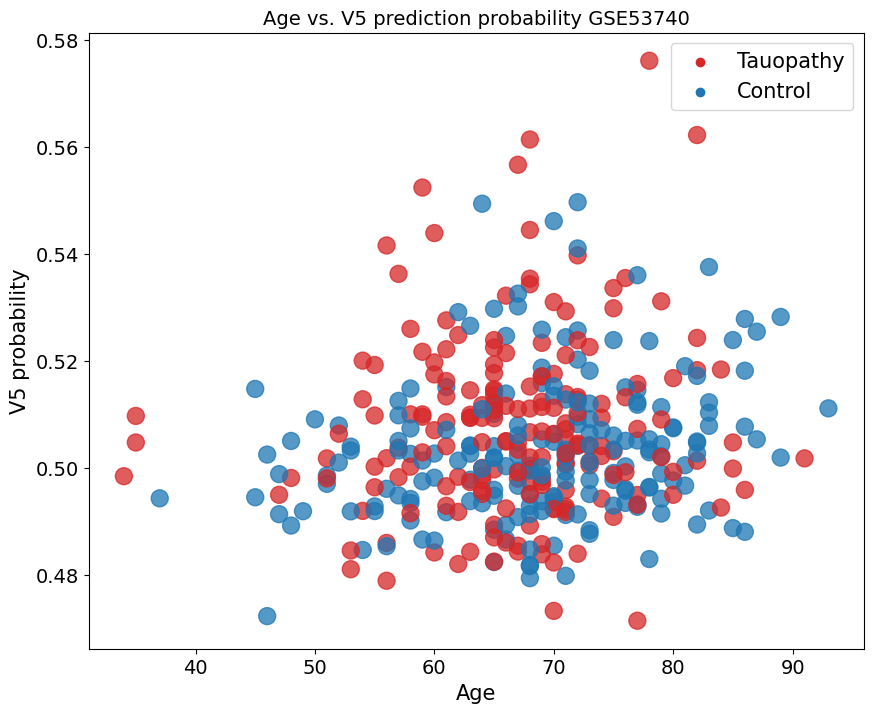

In [423]:
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(data=tau_meta, x='age', y='v5 disease_prob',hue='simple_disease_state', 
                                s=150, alpha=0.75, edgecolor="Face",palette=custom)

plt.xlabel('Age',fontsize=15)
plt.ylabel('V5 probability',fontsize=15)
plt.title('Age vs. V5 prediction probability {}'.format(tau_meta.series_id[0]),fontsize=14)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=15)
plt.savefig('Models/random_forests/V5/V5 RF disease probabilities scatter Tauopathy.png',dpi=300)

In [428]:
preds = clf.predict(dep.values)
probs = clf.predict_proba(dep.values)
get_accuracy(preds, dep_meta.healthy)

dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
dep_meta['v5 preds'] = preds
dep_meta['v5 disease_prob'] = dis
dep_meta['v5 health_prob'] = health

from scipy.stats import mannwhitneyu
conditions = ('Control','Case')
h_probs = dep_meta[dep_meta.healthy==0]['v5 disease_prob']
d_probs = dep_meta[dep_meta.healthy==1]['v5 disease_prob']
# Perform the Mann-Whitney U test
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)

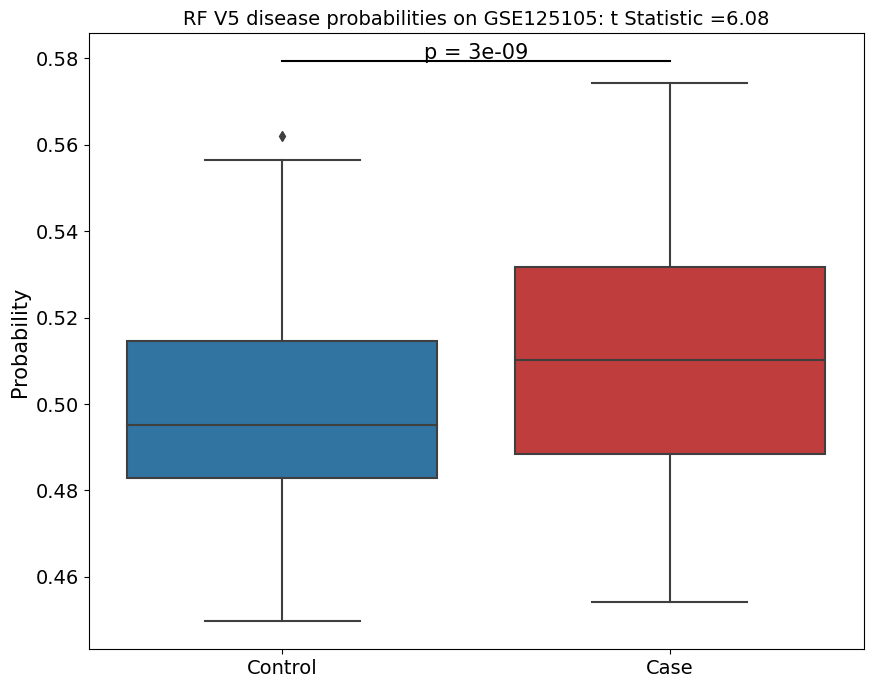

In [429]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=dep_meta, x='disease_state', y='v5 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V5 disease probabilities on {}: t Statistic ={:.2f}'.format(dep_meta.series_id[0],statistic),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.005, max(d_probs) + 0.005], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.0055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('Models/random_forests/V5/V5 RF disease probabilities Depression.png',dpi=300)

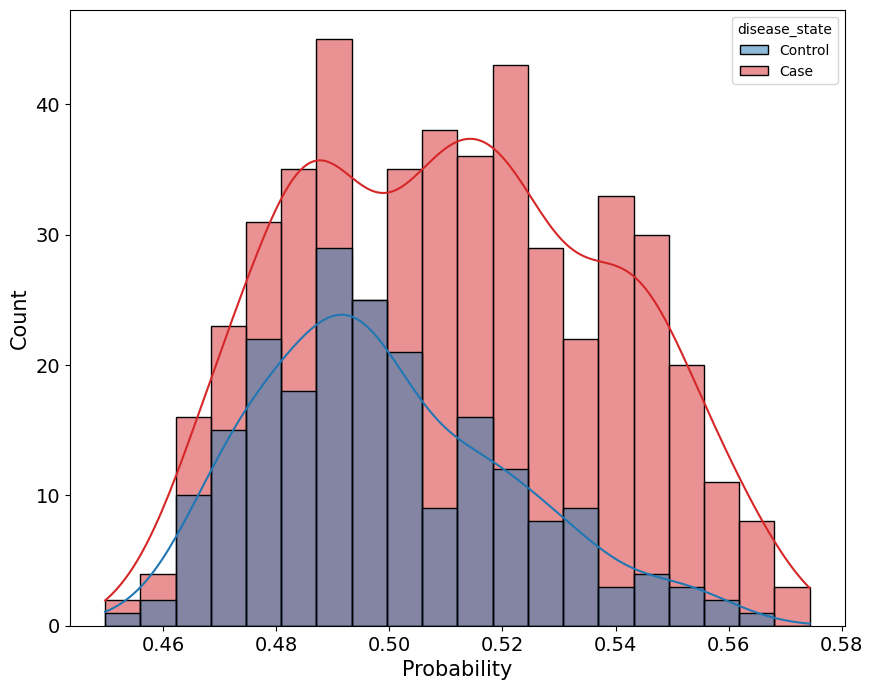

In [430]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
# Define the desired order of categories
sns.histplot( data=dep_meta, x=dep_meta['v5 disease_prob'], kde=True, bins=20, hue='disease_state', palette=custom_palette)

plt.xlabel('Probability',fontsize=15)
plt.ylabel('Count',fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Models/random_forests/V5/V5 RF disease probabilities hist Depression.png',dpi=300)

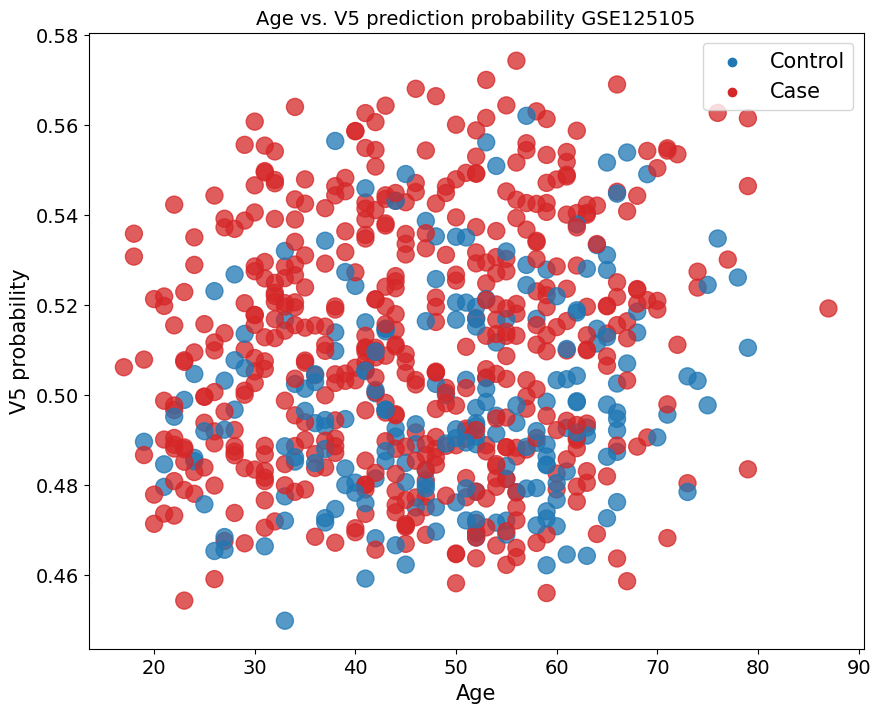

In [431]:
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(data=dep_meta, x='age', y='v5 disease_prob',hue='disease_state', 
                                s=150, alpha=0.75, edgecolor="Face",palette=custom)

plt.xlabel('Age',fontsize=15)
plt.ylabel('V5 probability',fontsize=15)
plt.title('Age vs. V5 prediction probability {}'.format(dep_meta.series_id[0]),fontsize=14)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=15)
plt.savefig('Models/random_forests/V5/V5 RF disease probabilities scatter Depression.png',dpi=300)

In [1016]:
preds = clf.predict(artp.values)
probs = clf.predict_proba(artp.values)
get_accuracy(preds, art_meta.healthy)

(0.8287373004354136,
 (309, 73, 262, 45),
 (0.8728813559322034, 0.21791044776119403))

In [1018]:
dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
art_meta['v5 preds'] = preds
art_meta['v5 disease_prob'] = dis
art_meta['v5 health_prob'] = health

In [1019]:
from scipy.stats import mannwhitneyu
conditions = ('Normal','Rheumatoid arthritis')
h_probs = art_meta[art_meta.healthy==0]['v5 disease_prob']
d_probs = art_meta[art_meta.healthy==1]['v5 disease_prob']
# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(h_probs, d_probs)

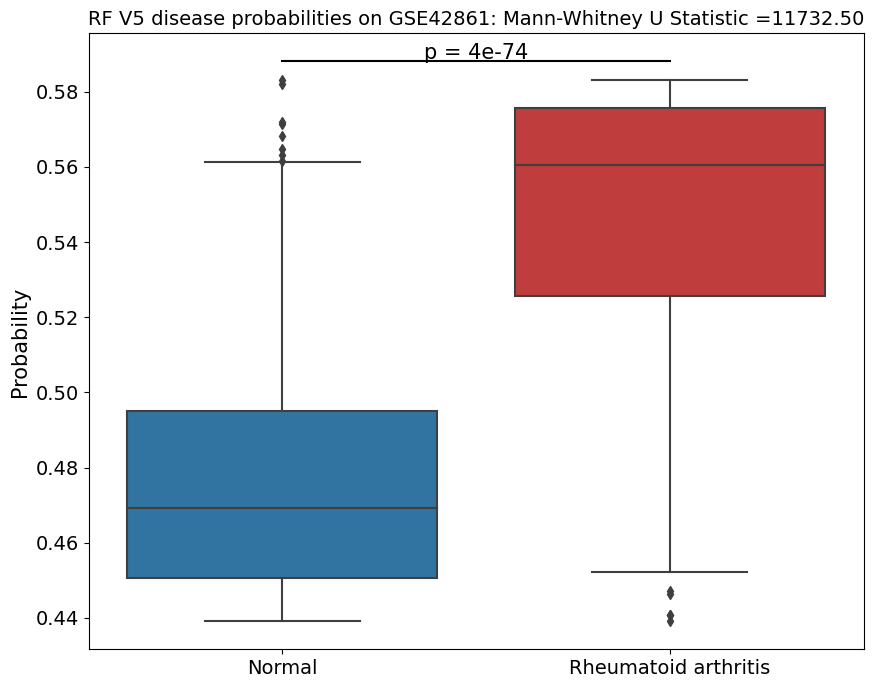

In [1020]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=art_meta, x='disease_state', y='v5 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V5 disease probabilities on {}: Mann-Whitney U Statistic ={:.2f}'.format(art_meta.series_id[0],statistic, p_value),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.005, max(d_probs) + 0.005], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.0055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('Models/random_forests/V5/V5 RF disease probabilities Arthritis.png',dpi=300)

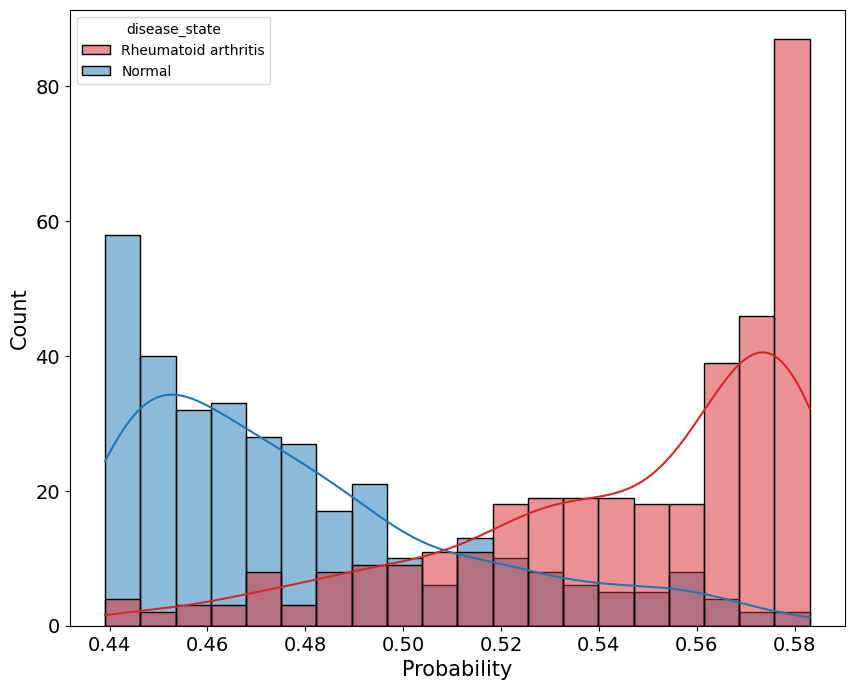

In [1023]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
# Define the desired order of categories
sns.histplot( data=art_meta, x=art_meta['v5 disease_prob'], kde=True, bins=20, hue='disease_state', palette=custom_palette)

plt.xlabel('Probability',fontsize=15)
plt.ylabel('Count',fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Models/random_forests/V5/V5 RF disease probabilities hist Arthritis.png',dpi=300)

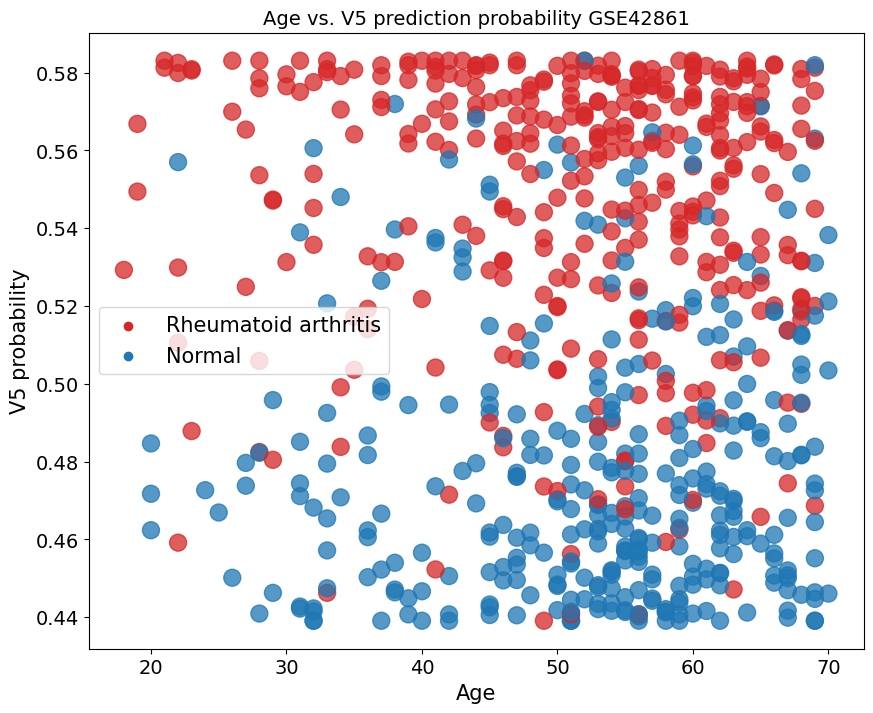

In [1024]:
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(data=art_meta, x='age', y='v5 disease_prob',hue='disease_state', 
                                s=150, alpha=0.75, edgecolor="Face",palette=custom)

plt.xlabel('Age',fontsize=15)
plt.ylabel('V5 probability',fontsize=15)
plt.title('Age vs. V5 prediction probability {}'.format(art_meta.series_id[0]),fontsize=14)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=15)
plt.savefig('Models/random_forests/V5/V5 RF disease probabilities scatter Arthritis.png',dpi=300)

In [1025]:
art_meta.to_excel('Datasets/Arthritis/Arthritis_pmeta.xlsx')

In [1026]:
file_path = 'Datasets/Arthritis2/'
art = np.load(file_path+'Arthritis2.npy', allow_pickle=True)
art_meta = pd.read_excel(file_path+'Arthritis2_pmeta.xlsx')
art_cgs = list_reader(file_path+'cgs.txt')
art_df = pd.DataFrame(art, columns=art_cgs)

In [1027]:
artp = art_df[cgs[:]]

In [1028]:
preds = clf.predict(artp.values)
probs = clf.predict_proba(artp.values)
get_accuracy(preds, art_meta.healthy)

(0.25882352941176473, (9, 0, 13, 63), (0.125, 0.0))

In [1029]:
dis =[]
health = []
for i in range(len(probs)):
    dis+=[probs[i][1]]
    health+=[probs[i][0]]
art_meta['v5 preds'] = preds
art_meta['v5 disease_prob'] = dis
art_meta['v5 health_prob'] = health

In [1030]:
from scipy.stats import mannwhitneyu
conditions = ('Control','UA')
h_probs = art_meta[art_meta.healthy==0]['v5 disease_prob']
d_probs = art_meta[art_meta.healthy==1]['v5 disease_prob']
# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(h_probs, d_probs)

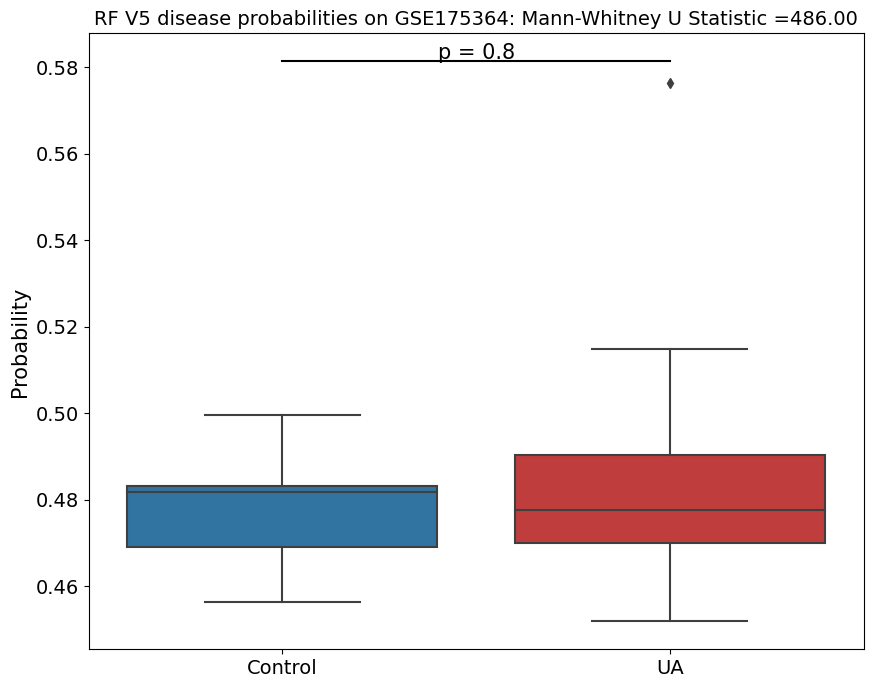

In [1034]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=art_meta, x='disease_state_init', y='v5 disease_prob', order=category_order, palette=custom_palette)
plt.title('RF V5 disease probabilities on {}: Mann-Whitney U Statistic ={:.2f}'.format(art_meta.series_id[0],statistic, p_value),fontsize=14)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_probs) + 0.005, max(d_probs) + 0.005], 'k-', lw=1.5)
plt.text(0.5, max(d_probs) + 0.0055, f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xlabel(None)
plt.ylabel('Probability',fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('Models/random_forests/V5/V5 RF disease probabilities Arthritis2.png',dpi=300)

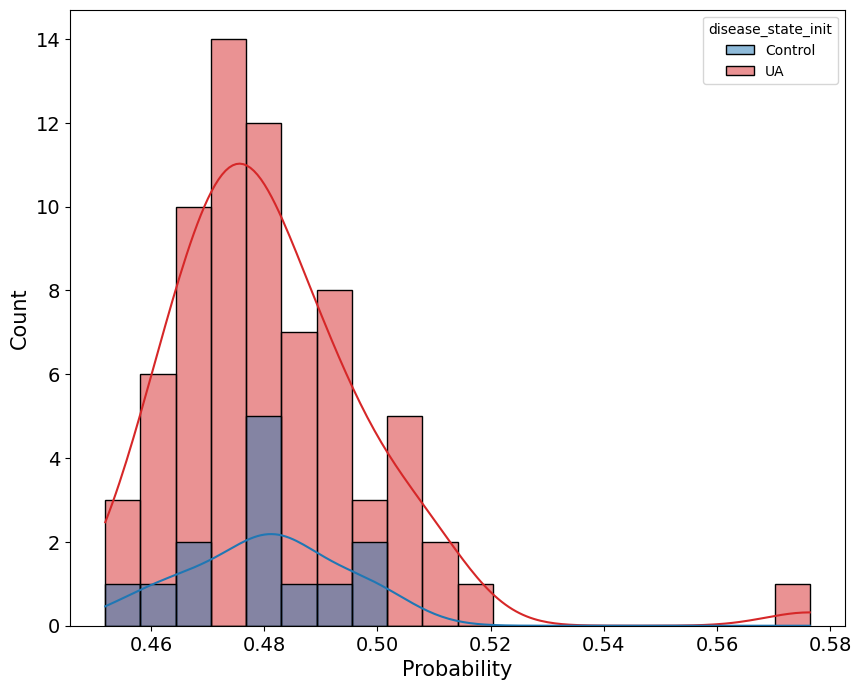

In [1035]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
# Define the desired order of categories
sns.histplot( data=art_meta, x=art_meta['v5 disease_prob'], kde=True, bins=20, hue='disease_state_init', palette=custom_palette)

plt.xlabel('Probability',fontsize=15)
plt.ylabel('Count',fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Models/random_forests/V5/V5 RF disease probabilities hist Arthritis2.png',dpi=300)

This complete failure is likely due to all case samples being undifferent arthritis. It may be that the effect on blood is not yet detectable  

In [2088]:
del art, art_meta, art_df, artp

In [1036]:
file_path = 'Datasets/PESA/'
pesa = np.load(file_path+'PESA.npy', allow_pickle=True)
pesa_meta = pd.read_excel(file_path+'PESA_pmeta.xlsx')
pesa_cgs = list_reader(file_path+'cgs.txt')
pesa_df = pd.DataFrame(pesa, columns=pesa_cgs)

In [687]:
# Define the hyperparameter space
space = {
    'max_depth': hp.uniformint('max_depth', 1, 100),
    'n_estimators': hp.uniformint('n_estimators', 50, 300),
    'min_samples_split':hp.uniformint('min_samples_split', 1, 15),
    'min_samples_leaf':hp.uniformint('min_samples_leaf', 1, 15),
    'min_impurity_decrease': hp.loguniform('min_impurity_decrease', -5, 0),
    'ccp_alpha': hp.loguniform('ccp_alpha', -5, -0),
}

# Define the objective function to minimize
def objective(params):
    clf = RandomForestClassifier(**params, n_jobs=-1, bootstrap=False)
    clf.fit(x_train, y_train.healthy)
    preds = clf.predict(x_val)
    score = accuracy_score(y_val.healthy, preds)
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=200)
print("Best set of hyperparameters: ", best_params)

100%|█████████████████████████████████████████████| 200/200 [02:04<00:00,  1.61trial/s, best loss: -0.6482084690553745]
Best set of hyperparameters:  {'ccp_alpha': 0.006928328066829866, 'max_depth': 2.0, 'min_impurity_decrease': 0.0067928298017075235, 'min_samples_leaf': 12.0, 'min_samples_split': 1.0, 'n_estimators': 170.0}


In [686]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp

# Define the hyperparameter space
space = {
    'max_depth': hp.uniformint('max_depth', 2, 8),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

# Define the objective function to minimize
def objective(params):
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(x_train.values, y_train.healthy)
    y_pred = xgb_model.predict(x_val.values)
    score = accuracy_score(y_val.healthy, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

100%|█████████████████████████████████████████████| 100/100 [17:06<00:00, 10.27s/trial, best loss: -0.7296416938110749]
Best set of hyperparameters:  {'learning_rate': 0.021000300198316113, 'max_depth': 8.0, 'subsample': 0.5909972553853899}


In [77]:

# Define your hyperparameters here
rf_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'min_impurity_decrease': 0.0,
    'n_jobs': -1,
    'bootstrap': False,
}

# Create the Random Forest classifier
clf = RandomForestClassifier(**rf_params)

# Create a k-fold cross-validation object
kf = KFold(n_splits=10, shuffle=True)

# Prepare your feature matrix X and target vector y
X = pag_df[pag_importances.CpG[:45000]]
y = pag_meta.healthy

# Use 10-fold cross-validation with accuracy scoring
accuracy_scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=kf, scoring=accuracy_scorer)

# Print the accuracy scores for each fold
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")

# Calculate statistics on the accuracy scores
mean_accuracy = scores.mean()
std_accuracy = scores.std()

print(f"Mean Accuracy: {mean_accuracy}")
print(f"Standard Deviation: {std_accuracy}")

Fold 1: 0.76
Fold 2: 0.64
Fold 3: 0.7755102040816326
Fold 4: 0.9387755102040817
Fold 5: 0.7346938775510204
Fold 6: 0.6938775510204082
Fold 7: 0.6530612244897959
Fold 8: 0.7346938775510204
Fold 9: 0.673469387755102
Fold 10: 0.673469387755102
Mean Accuracy: 0.7277551020408163
Standard Deviation: 0.08262438403996836


<AxesSubplot: xlabel='healthy', ylabel='cg24501381'>

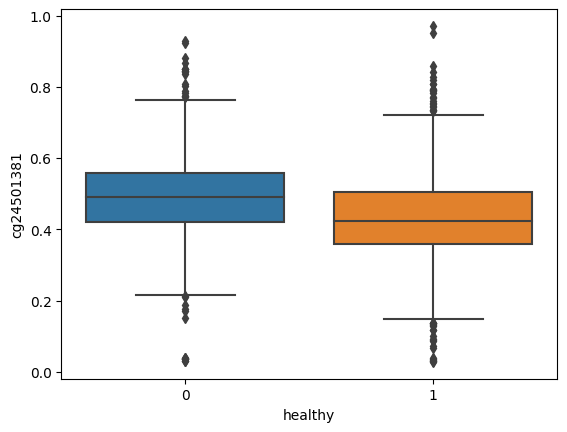

In [2139]:
sns.boxplot(x = meta.healthy, y=df['cg24501381'])